# NOAA Dataset: Exploratory Data Analysis

 The primary goal of this initial EDA is to understand the raw data's structure, content, and potential issues before any modification. This phase is about diagnosis. The tasks that are performed include inspection of the dataset's shape, identification of the features it contains, checking their data types, and looking for obvious problems like missing data or inconsistent naming. This is helpful downstream for planning an effective preprocessing strategy.

## Setup and Data Loading

 The first step is to setup the environment and load the data from the provided file paths into a unified structure. Using `pandas.concat` is an efficient way to combine multiple CSV files that share a similar (but non-identical) structure into a single DataFrame, which allows analyses of the entire dataset at once.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import io
import statsmodels.api as sm

from IPython.display import display, HTML
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot

sns.set_theme(style="whitegrid")

In [25]:
files = ['../data/source/NOAA_46041.csv', '../data/source/NOAA_46050.csv', '../data/source/NOAA_46243.csv']
dataframes = [pd.read_csv(file) for file in files]
df = pd.concat(dataframes, ignore_index=True)

df['date_time'] = pd.to_datetime(df['date_time'])

df.head()

,station_id,latitude (degrees north),longitude (degrees east),date_time,air_temperature (C°),sea_level_pressure (hPa),wind_speed (m/s),gust_speed (m/s),significant_wave_height (m),dominant_wave_period (s),sea_surface_temperature (C°),wind_speed_cwind (m/s)
0,2868187,47.348999,-124.708,2013-04-18 00:50:00+00:00,7.2,1032.599976,5.0,8.0,1.0,8.0,10.1,NaN
1,2868187,47.348999,-124.708,2013-04-18 01:50:00+00:00,6.8,1032.300049,4.0,5.0,1.1,6.0,10.0,NaN
2,2868187,47.348999,-124.708,2013-04-18 02:50:00+00:00,6.9,1031.800049,3.0,4.0,1.1,7.0,10.0,NaN
3,2868187,47.348999,-124.708,2013-04-18 03:50:00+00:00,7.0,1031.699951,2.0,3.0,1.0,6.0,9.9,NaN
4,2868187,47.348999,-124.708,2013-04-18 04:50:00+00:00,7.1,1031.900024,1.0,2.0,0.9,8.0,9.9,NaN


## 1. Initial Data Exploration

Here, a high-level "health check" of the dataset is performed. `.info()`  is important here as it provides the dimensions of the data, column names, the count of non-null values, and the data type for each column. .`describe()` gives the first statistical summary of the numerical columns. This initial look will highlight mismatched columns (leading to `NaN` values), incorrect data types, and potential inconsistencies in column naming.

In [26]:
buffer = io.StringIO()
df.info(buf=buffer)
info = buffer.getvalue()

html = f"<pre style='font-family: monospace; border-style: solid; border-width: thin; padding:10px;'>{info}</pre>"
display(HTML(html))

**Dimensions:** The dataset contains 7,219 rows (individual measurements) and 12 columns (features).

**Data Types (Dtype):** The data types are mostly appropriate. The date_time column has been successfully converted to a datetime64[ns, UTC] object, which is essential for any time-series analysis. The other columns are all numerical (int64 or float64), which is expected.

**Non-Null Count:** This is the most critical part of the summary showing a major discrepancy in the number of non-null values across columns.

- **Complete Columns:** station_id, latitude, longitude, and date_time are complete, providing a solid index and location for every single record.

- **Sparsely Populated Columns:** `air_temperature`, `sea_level_pressure`, `wind_speed`, and `gust_speed` each have only 723 non-null values (~10% of the data) which strongly implies that these measurements all originate from a single source file (likely `NOAA_46041.csv`).

- **Partially Populated Columns:** `significant_wave_height`, `dominant_wave_period`, and `sea_surface_temperature` have around 2,167 values (~30% of the data) which suggests they come from two of the three source files.
  
- **The Second Wind Speed:** The `wind_speed_cwind (m/s)` column has 4,320 values (~60% of the data), confirming it comes from a different source file than the first `wind_speed (m/s)` column.

In [27]:
print("Descriptive Statistics:")
df.describe()

Descriptive Statistics:


,station_id,latitude (degrees north),longitude (degrees east),air_temperature (C°),sea_level_pressure (hPa),wind_speed (m/s),gust_speed (m/s),significant_wave_height (m),dominant_wave_period (s),sea_surface_temperature (C°),wind_speed_cwind (m/s)
count,7.219000e+03,7219.000000,7219.000000,723.000000,723.000000,723.000000,723.000000,2167.000000,2167.000000,2168.000000,4320.000000
mean,2.872875e+06,45.226075,-124.470156,9.872752,1021.996403,5.063624,6.203320,1.304799,8.854176,11.113745,5.894028
std,8.068716e+03,0.942759,0.178761,1.409472,5.944653,2.339908,2.721901,0.455453,2.748450,1.280569,2.735111
min,2.868187e+06,44.639000,-124.708000,6.600000,1007.700012,0.000000,0.000000,0.400000,3.000000,8.500000,0.000000
25%,2.868934e+06,44.639000,-124.533997,8.800000,1017.599976,3.000000,4.000000,1.000000,7.000000,10.300000,3.800000
50%,2.868934e+06,44.639000,-124.533997,9.900000,1022.599976,5.000000,6.000000,1.300000,8.000000,10.900000,5.800000
75%,2.868934e+06,46.216000,-124.533997,10.900000,1025.599976,7.000000,8.000000,1.600000,10.000000,11.800000,8.100000
max,2.888997e+06,47.348999,-124.127998,14.700000,1035.699951,12.000000,16.000000,3.100000,18.000000,15.500000,12.100000


**Count:** 

- This row confirms the non-null counts shown in the `.info()` output.

**Mean & Standard Deviation (std):**

- The `average air_temperature` (9.9°C) is slightly lower than the `average sea_surface_temperature` (11.1°C), which is physically plausible for this region.

- The two wind speed columns (`wind_speed (m/s)` and `wind_speed_cwind (m/s)`) have similar means (5.1 vs 5.9 m/s) and standard deviations (2.3 vs 2.7 m/s). This strengthens the hypothesis that they measure the same phenomenon and can likely be merged.

- The average `significant_wave_height` is 1.3 meters, with a standard deviation of 0.46 meters providing a baseline for the typical sea state.

**Min/Max Values:**

- The maximum `significant_wave_height` recorded is 3.1 meters, and the maximum wind_speed is 12.0 m/s (with gusts to 16.0 m/s). This indicates the dataset captures moderately rough conditions but no extreme, hurricane-level storms.

- The `dominant_wave_period` reaches a maximum of 18 seconds. This is a very long period, indicative of a powerful, long-wavelength swell likely generated by a distant storm system.

**Percentiles (25%, 50%, 75%):**

- The median (50%) `sea_level_pressure` is 1022.6 hPa. Since standard pressure is ~1013 hPa, this suggests that the data was collected during a period dominated by high-pressure systems, which are generally associated with calmer weather.

- The interquartile range (IQR) for `significant_wave_height` is from 1.0m to 1.6m. This means that 50% of all wave measurements fall within this narrow 0.6-meter range, indicating relatively consistent sea conditions for the bulk of the observation period.

In [28]:
columns_str = "\n".join(df.columns)

html = f"<pre style='font-family: monospace; border-style: solid; border-width: thin; padding:10px;'>{columns_str}</pre>"
display(HTML(html))

In [29]:
wave_height_data = df.dropna(subset=['significant_wave_height (m)'])

daily_counts = df['date_time'].dt.date.value_counts().sort_index()
wave_counts = wave_height_data['date_time'].dt.date.value_counts().sort_index()

html = f"""
<div style="display: flex; width: 100%;">
  <div style="flex: 1 1 0; min-width: 0; padding-right: 10px; overflow: auto;">
    <h4 style="font-family: monospace;">WVHT (m) per Date</h4>
    <pre style="font-family: monospace; border: 1px solid; padding: 10px;">{wave_counts}</pre>
  </div>
  <div style="flex: 1 1 0; min-width: 0; padding-left: 10px; overflow: auto;">
    <h4 style="font-family: monospace;">Entries per Date</h4>
    <pre style="font-family: monospace; border: 1px solid; padding: 10px;">{daily_counts}</pre>
  </div>
</div>
"""

display(HTML(html))

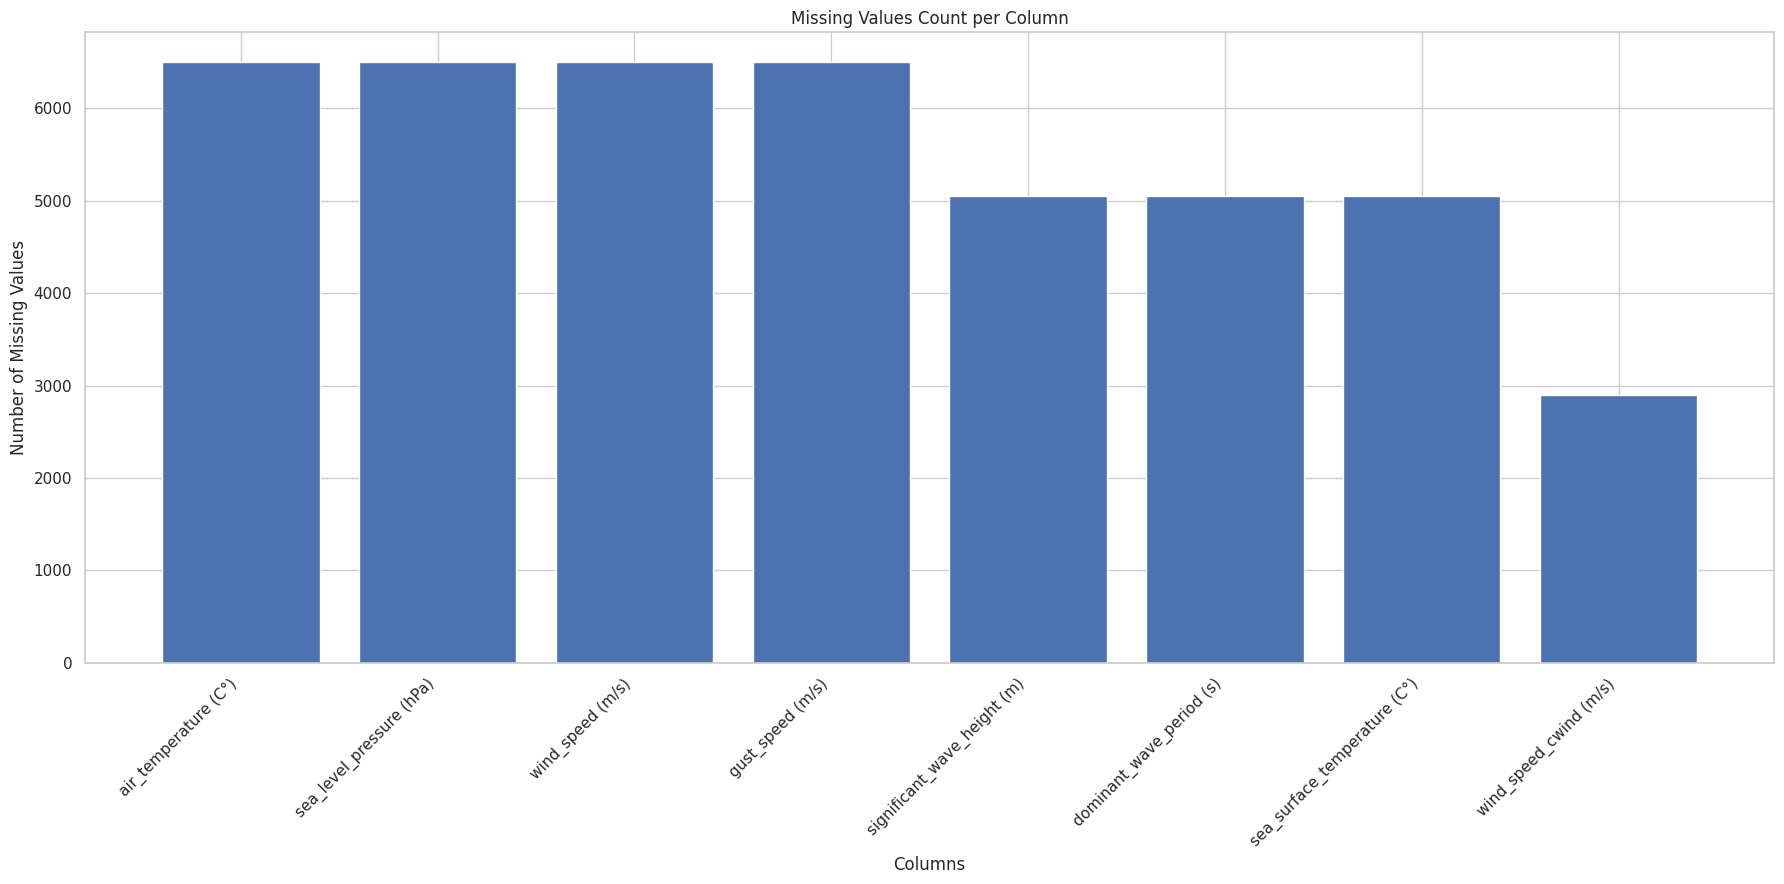

In [30]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    plt.figure(figsize=(18, 9))
    bars = plt.bar(missing_values.index, missing_values.values)
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.title('Missing Values Count per Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the DataFrame.")

**Column Naming Convention:** The column names are descriptive but might cause errors for coding. They contain spaces and special characters (e.g., C°). This confirms that a column name standardization step might be a necessary part of preprocessing for cleaner code.

**Missing Values Count:** This is the most important representation of the data sparsity problem as it quantifies how many values are missing in each column.

- Nearly 90% of the `air_temperature` and related records are missing.

- About 70% of the `significant_wave_height` records are missing.

- The two wind speed columns have 90% and 40% missing values, respectively.

> **NOTE**
>
> The output from this section makes it clear that the most significant challenge in this dataset is the missing data. Any modeling performed without addressing this will be flawed and a preprocessing strategy cannot simply be `dropna()` as this would discard almost all the data. Instead, it must focus on merging columns and then making an informed decision on how to handle the remaining `NaN`s in each feature.

## 2. Feature Analysis and Context

### 2.1. Feature Details

| Feature | Unit | Contextual Meaning |
|---|---|---|
| `station_id` | Identifier | A unique identifier for the NOAA buoy or monitoring station. |
| `latitude / longitude` | Degrees | Angular distance from the equator measured northward (+) and the angular distance between the prime meridian and the meridian of a point on the earth, measured eastward (+). |
| `date_time` | UTC | The timestamp of when the measurement was recorded for data display and data files. |
| `air_temperature` | Celsius | The temperature of the air, which can influence sea surface temperature and local weather. |
| `sea_level_pressure` | Hectopascals (hPa) | The atmospheric pressure at mean sea level. Standard pressure is ~1013 hPa. Low pressure is often associated with unsettled weather and storms, while high pressure indicates calm conditions. For C-MAN sites and Great Lakes buoys, the recorded pressure is reduced to sea level. |
| `wind_speed` | Meters/second (m/s)  | Averaged over an eight-minute period for buoys and a two-minute period for land stations. |
| `gust_speed` | Meters/second (m/s) | Peak 5 or 8 second gust speed measured during the eight-minute or two-minute period. |
| `significant_wave_height` | Meters (m) | Calculated as the average of the highest one-third of all of the wave heights during the 20-minute sampling period. |
| `dominant_wave_period` | Seconds (s) | Period with the maximum wave energy. It is the time between successive wave crests for the most energetic waves in the sea. A short period (<6s) indicates choppy, local wind-driven waves, while a long period (>10s) indicates smoother, more powerful swells from distant storms. |
| `sea_surface_temperature` | Celsius | The temperature of the water at the surface. It is a key indicator for marine ecosystems and influences air temperature and weather. |

### 2.2. Buoy Station Metadata

<table style="width:100%; border-collapse: collapse;" border="1">
  <thead>
    <tr>
      <th>Station</th>
      <th>Name</th>
      <th>Buoy</th>
      <th>Type</th>
      <th>Payload</th>
      <th>Platform Metadata</th>
      <th>Coordinates</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>46041</strong></td>
      <td>Cape Elizabeth &mdash; <em>45NM NW of Aberdeen, WA</em></td>
      <td style="text-align:center;"><img src="../assets/46041.jpg" alt="Buoy 46041" width="100"/></td>
      <td>3-meter discus w/ seal cage</td>
      <td>SCOOP</td>
      <td>
        Site elevation: sea level<br>
        Air temp height: 3.4 m<br>
        Anemometer height: 3.8 m<br>
        Barometer elevation: 2.4 m<br>
        Sea temp depth: 2 m<br>
        Water depth: 131 m<br>
        Watch circle radius: 167 yards
      </td>
      <td>
        47.352° N<br>124.739° W<br>
        <em>(47°21'9" N 124°44'22" W)</em>
      </td>
    </tr>
    <tr>
      <td><strong>46050</strong></td>
      <td>Stonewall Bank &mdash; <em>20NM West of Newport, OR</em></td>
      <td style="text-align:center;"><img src="../assets/46050.jpg" alt="Buoy 46050" width="100"/></td>
      <td>3-meter foam buoy</td>
      <td>SCOOP</td>
      <td>
        Site elevation: sea level<br>
        Air temp height: 3.4 m<br>
        Anemometer height: 3.8 m<br>
        Barometer elevation: 2.4 m<br>
        Sea temp depth: 2 m<br>
        Water depth: 149 m<br>
        Watch circle radius: 231 yards
      </td>
      <td>
        44.679° N<br>124.535° W<br>
        <em>(44°40'46" N 124°32'6" W)</em>
      </td>
    </tr>
    <tr>
      <td><strong>46243</strong></td>
      <td>Clatsop Spit, OR</td>
      <td style="text-align:center;"><img src="../assets/46243.jpg" alt="Buoy 46243" width="100"/></td>
      <td>Waverider Buoy</td>
      <td>Scripps</td>
      <td>
        Site elevation: sea level<br>
        Sea temp depth: 0.46 m<br>
        Water depth: 24.4 m
      </td>
      <td>
        46.214° N<br>124.126° W<br>
        <em>(46°12'52" N 124°7'35" W)</em>
      </td>
    </tr>
  </tbody>
</table>

## 3. Data Aggregation

Before diving into detailed plots, it's useful to aggregate the data to get a high-level summary. Grouping by `station_id` allows a comparison of the overall conditions between the different buoy locations. Calculating `mean`, `standard deviation`, `min`, and `max` for key variables provides a statistical profile for each station, highlighting which locations experience, on average, stronger winds, higher waves, or greater variability. 

In [31]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(r'\s*\(C°\)', '_celsius', regex=True)
df.columns = df.columns.str.replace(r'\s*\(m/s\)', '_mps', regex=True)
df.columns = df.columns.str.replace(r'\s*\(hPa\)', '_hpa', regex=True)
df.columns = df.columns.str.replace(r'\s*\(s\)', '_s', regex=True)
df.columns = df.columns.str.replace(r'\s*\(m\)', '_m', regex=True)

df.columns = df.columns.str.replace(r'\s+', '_', regex=True)
df.columns = df.columns.str.replace(r'_{2,}', '_', regex=True)
df.columns = df.columns.str.lower()

df['wind_speed'] = df['wind_speed_mps'].combine_first(df['wind_speed_cwind_mps'])

In [32]:
aggregation_features = [
    'air_temperature_celsius',
    'sea_surface_temperature_celsius',
    'wind_speed',
    'significant_wave_height_m'
]

station_summary = df.groupby('station_id')[aggregation_features].agg(['mean', 'std', 'min', 'max'])

print("Aggregated Summary by Station ID:")
for station_id, row in station_summary.iterrows():
    print(f"\nStation {station_id}:")
    display(row.unstack(level=1).T) 

Aggregated Summary by Station ID:

Station 2868187:


,air_temperature_celsius,sea_surface_temperature_celsius,wind_speed,significant_wave_height_m
mean,9.872752,10.282988,5.063624,1.337535
std,1.409472,0.900478,2.339908,0.502273
min,6.600000,8.500000,0.000000,0.400000
max,14.700000,13.600000,12.000000,3.100000



Station 2868934:


,air_temperature_celsius,sea_surface_temperature_celsius,wind_speed,significant_wave_height_m
mean,NaN,NaN,5.894028,NaN
std,NaN,NaN,2.735111,NaN
min,NaN,NaN,0.000000,NaN
max,NaN,NaN,12.100000,NaN



Station 2888997:


,air_temperature_celsius,sea_surface_temperature_celsius,wind_speed,significant_wave_height_m
mean,NaN,11.529412,NaN,1.288443
std,NaN,1.239773,NaN,0.429405
min,NaN,9.000000,NaN,0.500000
max,NaN,15.500000,NaN,2.700000


**Station 2868187**
 
Station 2868187 is the most comprehensive monitoring buoy, recording air temperature, sea surface temperature, wind speed, and significant wave height. Over the observation period, the air temperature averaged 9.87 °C while the sea surface temperature was slightly higher at 10.28 °C which is typical of a coastal environment where the ocean moderates air temperatures. Wind speeds at this site averaged a moderate 5.06 m/s (≈ 11.3 mph) and peaked at 12.0 m/s (~b27 mph), indicating generally breezy but non‐storm conditions. Wave heights averaged 1.34 m (≈ 4.4 ft) with a maximum of 3.1 m (≈ 10.2 ft), consistent with the observed wind regime. As the only station providing all four key variables, `NOAA_46041.csv` offers a full picture of local weather and sea‐state dynamics.
 
**Station 2868934**
 
Station 2868934 functions as a dedicated wind monitoring site, with wind speed being the only measured variable. Its wind speed profile mirrors that of Station 2868187 but is slightly stronger on average, at 5.89 m/s, and reaches a comparable maximum of 12.1 m/s. The absence of temperature and wave data suggests this buoy is either equipped only with anemometric sensors or that only wind observations were included in the `NOAA_46050.csv` dataset. While valuable for wind‐focused analyses, it cannot contribute to studies requiring concurrent temperature or wave measurements.

**Station 2888997**
 
Station 2888997 only captures the sea surface temperature and significant wave height which indicates it probably has a wave‐rider buoy configuration. From `NOAA_46243.csv`, the mean sea surface temperature of 11.53 °C is noticeably warmer (about 1.25 °C above Station 2868187) which hints either a more southerly location or influence from a warmer ocean current. Despite the warmer waters, wave conditions are similar, with an average significant wave height of 1.29 m. This station’s data can be used for isolating sea‐state and thermal dynamics but cannot support atmospheric or wind‐wave coupling analyses.

In [33]:
df_indexed = df.set_index('date_time')

aggregations = {
    'wind_speed': ['mean', 'max', 'std'],
    'significant_wave_height_m': ['mean', 'max', 'std'],
    'sea_surface_temperature_celsius': ['mean', 'min', 'max']
}

daily_station_summary = df_indexed.groupby('station_id').resample('D').agg(aggregations).dropna(how='all')
daily_station_summary

wind_speed                 \
                                           mean  max       std   
station_id date_time                                             
2868187    2013-04-18 00:00:00+00:00   5.043478  8.0  2.476770   
           2013-04-19 00:00:00+00:00   6.416667  8.0  1.348644   
           2013-04-20 00:00:00+00:00   5.583333  7.0  1.442120   
           2013-04-21 00:00:00+00:00   4.826087  7.0  1.302172   
           2013-04-22 00:00:00+00:00   4.541667  7.0  2.431303   
...                                         ...  ...       ...   
2888997    2013-05-14 00:00:00+00:00        NaN  NaN       NaN   
           2013-05-15 00:00:00+00:00        NaN  NaN       NaN   
           2013-05-16 00:00:00+00:00        NaN  NaN       NaN   
           2013-05-17 00:00:00+00:00        NaN  NaN       NaN   
           2013-05-18 00:00:00+00:00        NaN  NaN       NaN   

                                     significant_wave_height_m                 \
                                                          mean  max       std   
station_id date_time                                                            
2868187    2013-04-18 00:00:00+00:00                  1.152174  1.7  0.339612   
           2013-04-19 00:00:00+00:00                  1.683333  2.0  0.137261   
           2013-04-20 00:00:00+00:00                  1.741667  2.0  0.141165   
           2013-04-21 00:00:00+00:00                  1.126087  1.4  0.128691   
           2013-04-22 00:00:00+00:00                  0.895833  1.1  0.112208   
...                                                        ...  ...       ...   
2888997    2013-05-14 00:00:00+00:00                  1.920833  2.4  0.203123   
           2013-05-15 00:00:00+00:00                  1.429167  1.8  0.190138   
           2013-05-16 00:00:00+00:00                  1.527660  1.9  0.234708   
           2013-05-17 00:00:00+00:00                  1.502083  1.8  0.124609   
           2013-05-18 00:00:00+00:00                  1.290909  1.4  0.115095   

                                     sea_surface_temperature_celsius        \
                                                                mean   min   
station_id date_time                                                         
2868187    2013-04-18 00:00:00+00:00                        9.956522   9.8   
           2013-04-19 00:00:00+00:00                        9.370833   9.1   
           2013-04-20 00:00:00+00:00                        9.204167   8.9   
           2013-04-21 00:00:00+00:00                        9.660870   9.5   
           2013-04-22 00:00:00+00:00                       10.295833   9.7   
...                                                              ...   ...   
2888997    2013-05-14 00:00:00+00:00                       13.587500  12.7   
           2013-05-15 00:00:00+00:00                       13.716667  12.9   
           2013-05-16 00:00:00+00:00                       13.234043  12.4   
           2013-05-17 00:00:00+00:00                       13.291667  12.5   
           2013-05-18 00:00:00+00:00                       13.463636  12.8   

                                            
                                       max  
station_id date_time                        
2868187    2013-04-18 00:00:00+00:00  10.1  
           2013-04-19 00:00:00+00:00   9.8  
           2013-04-20 00:00:00+00:00   9.6  
           2013-04-21 00:00:00+00:00   9.9  
           2013-04-22 00:00:00+00:00  12.5  
...                                    ...  
2888997    2013-05-14 00:00:00+00:00  15.2  
           2013-05-15 00:00:00+00:00  15.5  
           2013-05-16 00:00:00+00:00  14.6  
           2013-05-17 00:00:00+00:00  15.0  
           2013-05-18 00:00:00+00:00  14.1  

[93 rows x 9 columns]

**Data Structure:**
 
- 93 unique station-days in total.
 
- Grouped by station_id and daily timeline — ideal for time-series visualization.
 
**Station 2868187 (April 18–22):**

- April 18: Mean wind speed = 5.0 m/s.
 
- April 19: Wind increased to 6.4 m/s; wave height rose from 1.15 m to 1.68 m.
 
- April 20: Conditions remained rough.
 
- April 22: Wave height dropped to 0.9 m — storm system likely passed through and dissipated.
 
**Station 2888997 (May 14–18):**

- Sea surface temperature warmed from 13.5 °C to 13.7 °C before a slight dip.

- Significant waves on May 14 (2.4 m) with no wind data available.

- Suggests swell-driven wave activity from a distant storm.
 
**Overall Insight:**

- Enables tracking of short-term weather patterns and environmental changes.

- Best used for chronological analysis and visualization of events at each station.

In [34]:
# To make sorting easier, we can flatten the multi-level column index
daily_station_summary.columns = ['_'.join(col).strip() for col in daily_station_summary.columns.values]

print("Top 5 Roughest Sea Events (by Max Wave Height):")
display(daily_station_summary.sort_values('significant_wave_height_m_max', ascending=False).head(5))

Top 5 Roughest Sea Events (by Max Wave Height):


wind_speed_mean  wind_speed_max  \
station_id date_time                                                    
2868187    2013-04-29 00:00:00+00:00         9.000000            12.0   
           2013-04-30 00:00:00+00:00         9.130435            11.0   
2888997    2013-04-30 00:00:00+00:00              NaN             NaN   
           2013-04-29 00:00:00+00:00              NaN             NaN   
2868187    2013-05-14 00:00:00+00:00         3.875000             8.0   

                                      wind_speed_std  \
station_id date_time                                   
2868187    2013-04-29 00:00:00+00:00        1.615146   
           2013-04-30 00:00:00+00:00        1.140349   
2888997    2013-04-30 00:00:00+00:00             NaN   
           2013-04-29 00:00:00+00:00             NaN   
2868187    2013-05-14 00:00:00+00:00        1.623536   

                                      significant_wave_height_m_mean  \
station_id date_time                                                   
2868187    2013-04-29 00:00:00+00:00                        2.162500   
           2013-04-30 00:00:00+00:00                        2.708696   
2888997    2013-04-30 00:00:00+00:00                        2.329787   
           2013-04-29 00:00:00+00:00                        1.897917   
2868187    2013-05-14 00:00:00+00:00                        2.041667   

                                      significant_wave_height_m_max  \
station_id date_time                                                  
2868187    2013-04-29 00:00:00+00:00                            3.1   
           2013-04-30 00:00:00+00:00                            3.0   
2888997    2013-04-30 00:00:00+00:00                            2.7   
           2013-04-29 00:00:00+00:00                            2.5   
2868187    2013-05-14 00:00:00+00:00                            2.4   

                                      significant_wave_height_m_std  \
station_id date_time                                                  
2868187    2013-04-29 00:00:00+00:00                       0.448972   
           2013-04-30 00:00:00+00:00                       0.167639   
2888997    2013-04-30 00:00:00+00:00                       0.161400   
           2013-04-29 00:00:00+00:00                       0.378401   
2868187    2013-05-14 00:00:00+00:00                       0.161290   

                                      sea_surface_temperature_celsius_mean  \
station_id date_time                                                         
2868187    2013-04-29 00:00:00+00:00                              9.708333   
           2013-04-30 00:00:00+00:00                              9.147826   
2888997    2013-04-30 00:00:00+00:00                             10.857447   
           2013-04-29 00:00:00+00:00                             10.795833   
2868187    2013-05-14 00:00:00+00:00                             10.983333   

                                      sea_surface_temperature_celsius_min  \
station_id date_time                                                        
2868187    2013-04-29 00:00:00+00:00                                  9.2   
           2013-04-30 00:00:00+00:00                                  8.8   
2888997    2013-04-30 00:00:00+00:00                                 10.0   
           2013-04-29 00:00:00+00:00                                 10.1   
2868187    2013-05-14 00:00:00+00:00                                 10.7   

                                      sea_surface_temperature_celsius_max  
station_id date_time                                                       
2868187    2013-04-29 00:00:00+00:00                                 10.8  
           2013-04-30 00:00:00+00:00                                  9.9  
2888997    2013-04-30 00:00:00+00:00                                 11.6  
           2013-04-29 00:00:00+00:00                                 11.4  
2868187    2013-05-14 00:00:00+00:00                                 11.4

The data from April 29–30 reveal the most intense storm event in the dataset, with Station 2868187 recording peak wave heights of 3.1 meters alongside strong winds (mean 9.0 m/s), confirming a wind-driven sea. Station 2888997, lacking wind data, also registered high waves (2.7 m), and using the known storm conditions from 2868187, we can infer that it experienced the same system—demonstrating how one station's data can contextualize another. On May 14, however, 2868187 showed a different pattern: significant waves (2.4 m) occurred despite low wind speeds (3.87 m/s), indicating a distant swell rather than local wind influence. This contrast highlights a key oceanographic concept—the distinction between local wind seas and remotely generated swells.

In [35]:
print("Top 5 Windiest Events (by Max Wind Speed):")
display(daily_station_summary.sort_values('wind_speed_max', ascending=False).head(5))

Top 5 Windiest Events (by Max Wind Speed):


wind_speed_mean  wind_speed_max  \
station_id date_time                                                    
2868934    2013-05-03 00:00:00+00:00         9.906944            12.1   
2868187    2013-04-29 00:00:00+00:00         9.000000            12.0   
2868934    2013-04-24 00:00:00+00:00         7.789583            11.9   
           2013-04-23 00:00:00+00:00         9.262500            11.7   
           2013-05-02 00:00:00+00:00         8.329861            11.6   

                                      wind_speed_std  \
station_id date_time                                   
2868934    2013-05-03 00:00:00+00:00        1.157261   
2868187    2013-04-29 00:00:00+00:00        1.615146   
2868934    2013-04-24 00:00:00+00:00        2.161381   
           2013-04-23 00:00:00+00:00        1.579850   
           2013-05-02 00:00:00+00:00        2.154750   

                                      significant_wave_height_m_mean  \
station_id date_time                                                   
2868934    2013-05-03 00:00:00+00:00                             NaN   
2868187    2013-04-29 00:00:00+00:00                          2.1625   
2868934    2013-04-24 00:00:00+00:00                             NaN   
           2013-04-23 00:00:00+00:00                             NaN   
           2013-05-02 00:00:00+00:00                             NaN   

                                      significant_wave_height_m_max  \
station_id date_time                                                  
2868934    2013-05-03 00:00:00+00:00                            NaN   
2868187    2013-04-29 00:00:00+00:00                            3.1   
2868934    2013-04-24 00:00:00+00:00                            NaN   
           2013-04-23 00:00:00+00:00                            NaN   
           2013-05-02 00:00:00+00:00                            NaN   

                                      significant_wave_height_m_std  \
station_id date_time                                                  
2868934    2013-05-03 00:00:00+00:00                            NaN   
2868187    2013-04-29 00:00:00+00:00                       0.448972   
2868934    2013-04-24 00:00:00+00:00                            NaN   
           2013-04-23 00:00:00+00:00                            NaN   
           2013-05-02 00:00:00+00:00                            NaN   

                                      sea_surface_temperature_celsius_mean  \
station_id date_time                                                         
2868934    2013-05-03 00:00:00+00:00                                   NaN   
2868187    2013-04-29 00:00:00+00:00                              9.708333   
2868934    2013-04-24 00:00:00+00:00                                   NaN   
           2013-04-23 00:00:00+00:00                                   NaN   
           2013-05-02 00:00:00+00:00                                   NaN   

                                      sea_surface_temperature_celsius_min  \
station_id date_time                                                        
2868934    2013-05-03 00:00:00+00:00                                  NaN   
2868187    2013-04-29 00:00:00+00:00                                  9.2   
2868934    2013-04-24 00:00:00+00:00                                  NaN   
           2013-04-23 00:00:00+00:00                                  NaN   
           2013-05-02 00:00:00+00:00                                  NaN   

                                      sea_surface_temperature_celsius_max  
station_id date_time                                                       
2868934    2013-05-03 00:00:00+00:00                                  NaN  
2868187    2013-04-29 00:00:00+00:00                                 10.8  
2868934    2013-04-24 00:00:00+00:00                                  NaN  
           2013-04-23 00:00:00+00:00                                  NaN  
           2013-05-02 00:00:00+00:00                                  NaN

The wind data further confirms April 29th as the peak of the major storm event, with Station 2868187 recording its highest wind speed—12.0 m/s—on that day, aligning exactly with the roughest sea conditions. Meanwhile, Station 2868934, which exclusively measures wind, registered the four highest wind speeds in the entire dataset, peaking at 12.1 m/s on May 3rd. This suggests either a more exposed location or the influence of a different storm system. However, since wave data is entirely absent for this station, we cannot assess whether these strong winds led to corresponding wave activity, reinforcing the limitations imposed by data silos. Overall, this analysis not only verifies the April 29th storm but also underscores the complexity of wind-wave dynamics and the role of swell, especially when rough seas and peak winds don’t always coincide across stations.

## 4. Data Visualization

### 4.1 Univariate Analysis

Visualizing the distribution of individual features Histograms and Kernel Density Estimates (KDEs) show the distribution of values (is it symmetric, skewed, bimodal?). Box plots are excellent for summarizing the central tendency and spread, and for clearly identifying potential outliers. This enables better feature engineering and model building.

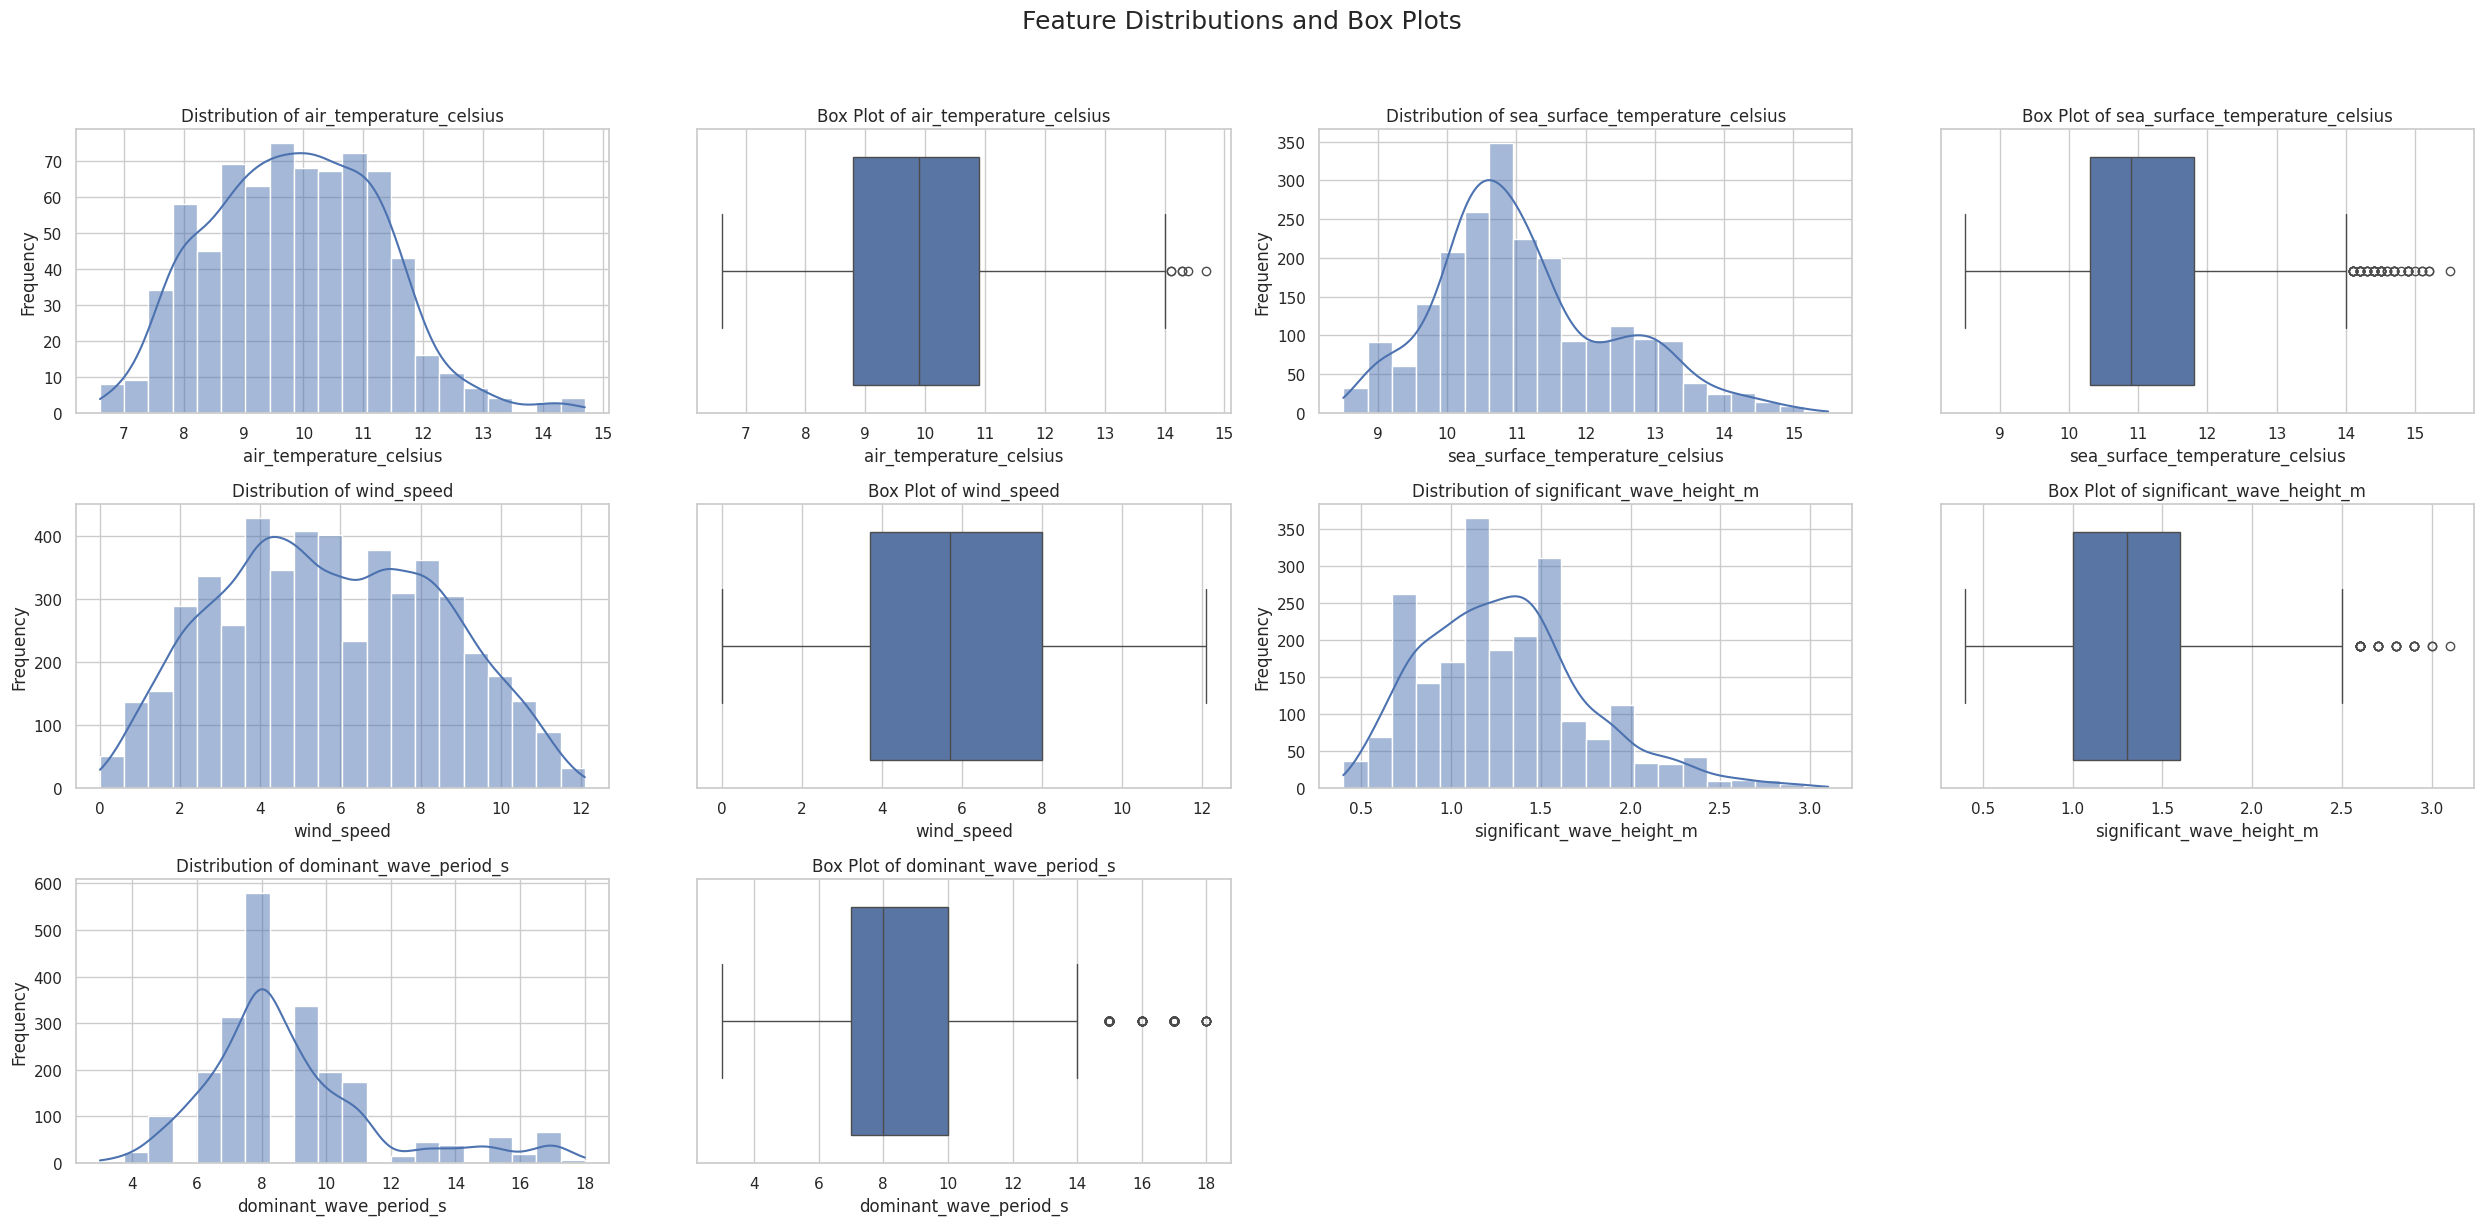

In [36]:
viz_cols = [
    'air_temperature_celsius', 'sea_surface_temperature_celsius',
    'wind_speed', 'significant_wave_height_m', 'dominant_wave_period_s'
]

n_features = len(viz_cols)
n_cols = 4
n_rows = (n_features + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 4 * n_rows))
fig.suptitle("Feature Distributions and Box Plots", fontsize=18, y=1.02)

for i, col in enumerate(viz_cols):
    row = i // 2
    col_pos = (i % 2) * 2  # 0 or 2

    data = df[col].dropna()
    color = sns.color_palette("tab20c")[i % 20]

    # Histogram
    sns.histplot(data, kde=True, bins=20, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Distribution of {col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=data, ax=axes[row, col_pos + 1])
    axes[row, col_pos + 1].set_title(f'Box Plot of {col}')
    axes[row, col_pos + 1].set_xlabel(col)

# Hide any unused subplots
if len(viz_cols) % 2 != 0:
    axes[-1, -2].axis('off')
    axes[-1, -1].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

<table style="width: 100%; border-collapse: collapse;">
  <tr>
    <td style="width: 50%; vertical-align: top; padding-right: 20px;">
      <p><strong>Air Temperature:</strong></p>
      <ul>
        <li>Bell-shaped (normal) distribution centered at 9–10 °C.</li>
        <li>Indicates a single, consistent source — likely one station.</li>
        <li>No evidence of multiple data sources or regional variation.</li>
      </ul>
      <p><strong>Wind Speed:</strong></p>
      <ul>
        <li>Symmetrical distribution centered around 4–8 m/s.</li>
        <li>Represents a broad but moderate range of wind conditions.</li>
        <li>No extreme outliers and no major storms or hurricanes recorded.</li>
      </ul>
      <p><strong>Dominant Wave Period:</strong></p>
      <ul>
        <li>Main peak at 8–9 seconds are typical local, wind-driven waves.</li>
        <li>Secondary peak and values &gt;14 seconds are distant, long-period swell events.</li>
      </ul>
    </td>
    <td style="width: 50%; vertical-align: top; padding-left: 20px;">
      <p><strong>Sea Surface Temperature:</strong></p>
      <ul>
        <li>Bimodal distribution suggests data from multiple stations.</li>
        <li>Cooler cluster around 11 °C, warmer cluster around 13 °C.</li>
        <li>Reflects geographic/environmental differences between locations.</li>
      </ul>
     <p><strong>Significant Wave Height:</strong></p>
      <ul>
        <li>Right-skewed distribution is common for calm seas (1.0–1.6 m).</li>
        <li>Values &gt;2.5 m are rare storm-driven events.</li>
      </ul>
    </td>
  </tr>
</table>

### 4.2 Multivariate Analysis

While univariate analysis is useful, the real insights often come from understanding the relationships between different variables. A correlation matrix will be used with a heatmap to get a quick overview of the linear relationships between all pairs of numerical variables. Scatter plots will then be used to visualize the relationships between specific pairs of interest.

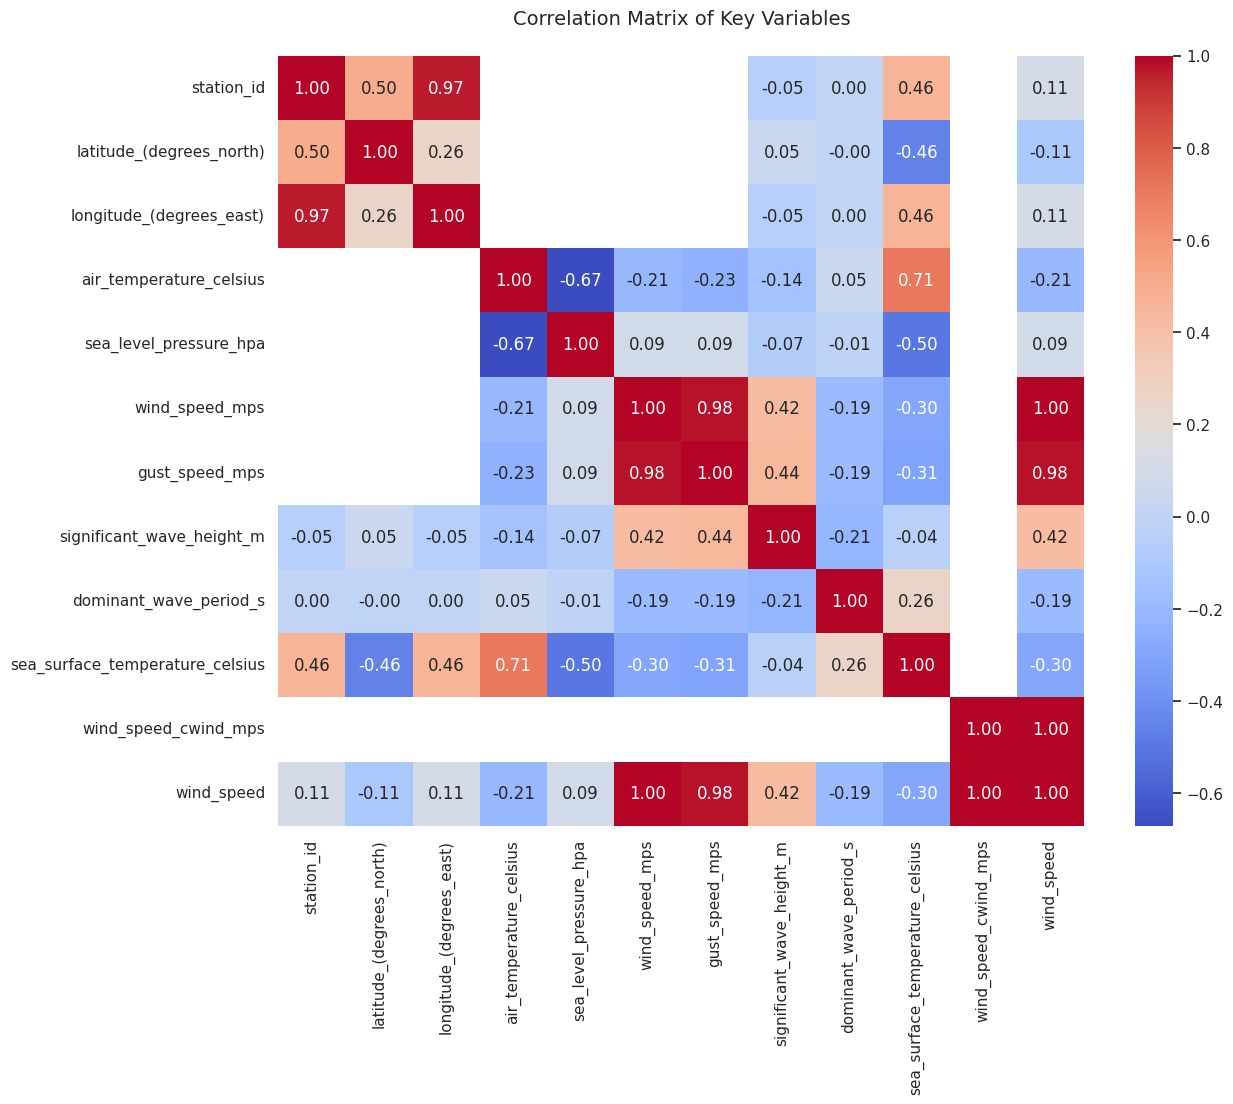

In [37]:
# Select only rows with no missing data for the key variables
df_complete = df[aggregation_features].dropna()

plt.figure(figsize=(13, 10))
numeric_df = df.select_dtypes(include=np.number)
numeric_df = numeric_df.dropna(axis=1, how='all')
corr_matrix = numeric_df.corr()

# Create heatmap and get current axis
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Set grid to match heatmap cells
ax.set_xticks(np.arange(len(corr_matrix.columns)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(corr_matrix.columns)) + 0.5, minor=False)
ax.grid(which="major", color='w', linestyle='-', linewidth=1)
ax.tick_params(which="major", bottom=False, left=False)

plt.title('Correlation Matrix of Key Variables', fontsize=14, y=1.03)
plt.show()

**Strongest Relationships (Red):**

- Wind speed and gust speed (+0.98) are nearly identical.

- Air and sea surface temperatures (+0.71) are strongly linked.

**Strongest Inverse Relationships (Blue):**

- Low sea-level pressure is strongly associated with colder air (-0.67) and cooler seas (-0.50), which is a storm signature.

**Key Physical Link:**

- Higher wind speed is moderately correlated with higher waves (+0.42).

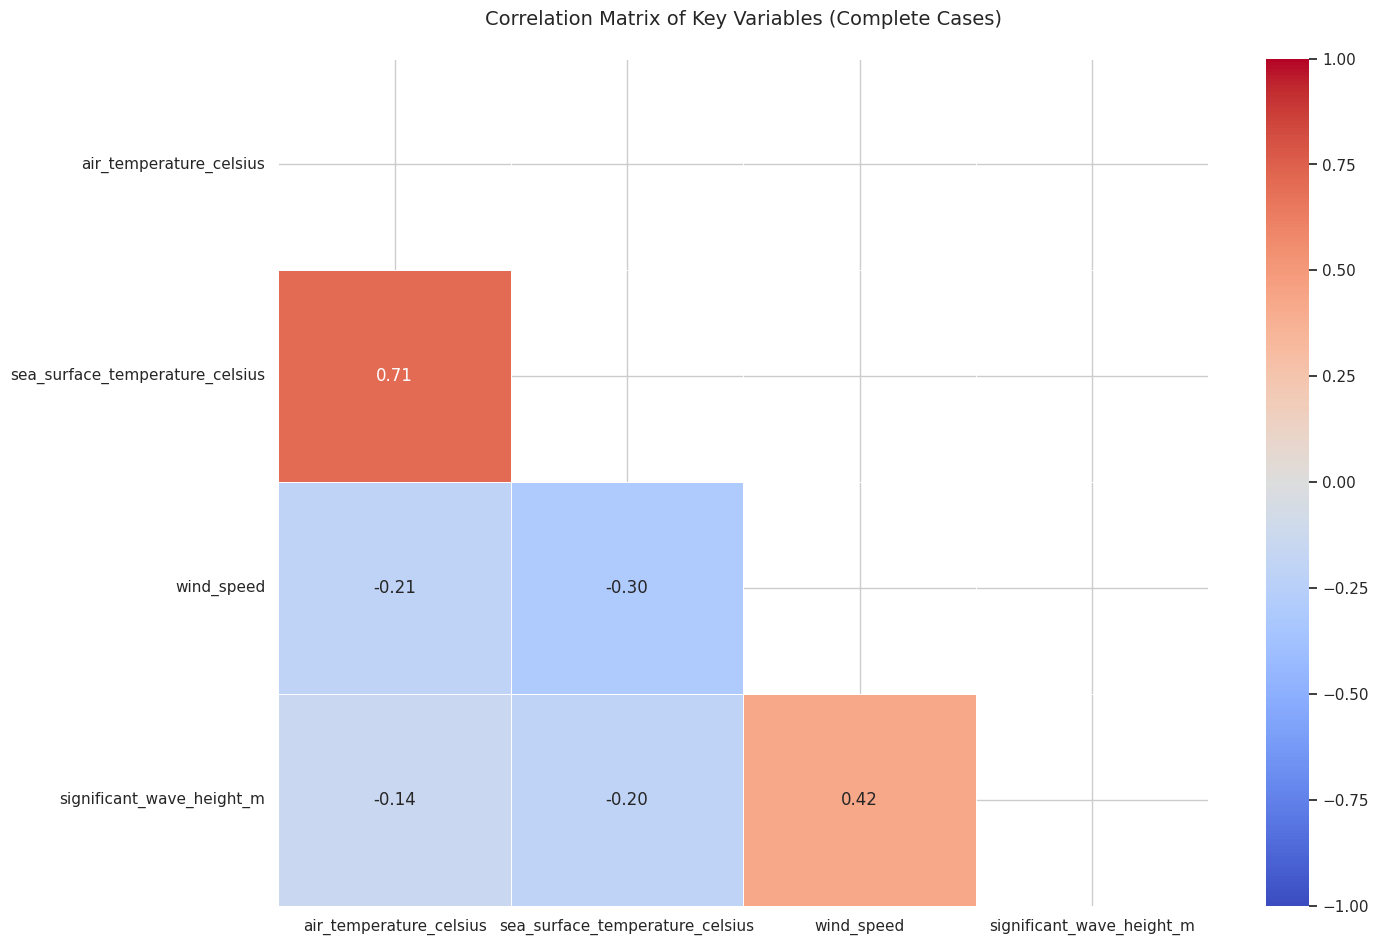

In [38]:
complete_corr = df_complete.corr()

# Create a boolean mask for the upper triangle
# np.triu creates a matrix of True values in the upper triangle
mask = np.triu(np.ones_like(complete_corr, dtype=bool))

plt.figure(figsize=(15, 11))

sns.heatmap(
    complete_corr,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.5,
    vmin=-1, vmax=1
)

# Visualize the plot
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of Key Variables (Complete Cases)', fontsize=14, y=1.03)
plt.show()

This heatmap shows the relationships between variables using only the clean, complete data from the single station that measures everything.

- **Strongest Positive (+0.71):** Air and sea surface temperature are very tightly linked.

- **Key Physical Link (+0.42):** Higher wind speed is moderately correlated with higher significant wave height.

- **Storm Signature (Weak Negative):** Colder temperatures are weakly associated with higher winds (-0.21, -0.30), which is typical for storm systems in this region.

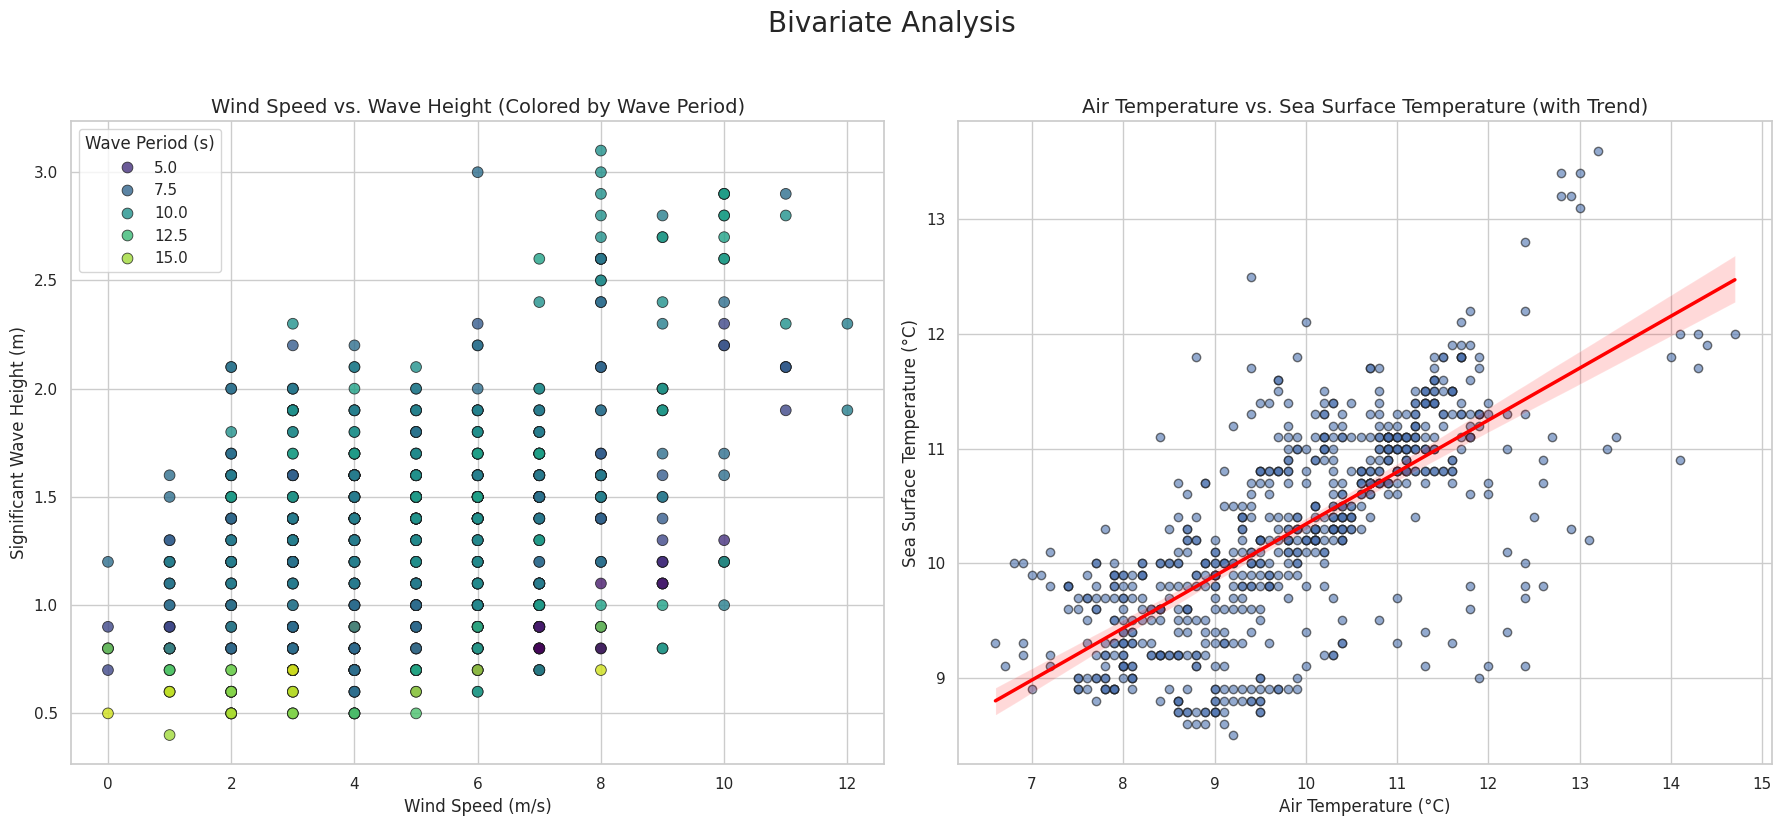

In [39]:
plt.figure(figsize=(18, 8))

# --- Wind Speed vs. Wave Height ---
wave_df = df[['wind_speed', 'significant_wave_height_m', 'dominant_wave_period_s']].dropna()

plt.subplot(1, 2, 1)

scatter_plot = sns.scatterplot(
    data=wave_df,
    x='wind_speed',
    y='significant_wave_height_m',
    hue='dominant_wave_period_s',
    palette='viridis',
    alpha=0.8,
    edgecolor='k',
    s=60
)
plt.title('Wind Speed vs. Wave Height (Colored by Wave Period)', fontsize=14)
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Significant Wave Height (m)', fontsize=12)
plt.grid(True)
scatter_plot.get_legend().set_title('Wave Period (s)')


# --- Air Temperature vs. Sea Surface Temperature ---
temp_df = df[['air_temperature_celsius', 'sea_surface_temperature_celsius']].dropna()

plt.subplot(1, 2, 2)
sns.regplot(
    data=temp_df,
    x='air_temperature_celsius',
    y='sea_surface_temperature_celsius',
    scatter_kws={'alpha':0.6, 'edgecolor':'k'},
    line_kws={'color':'red', 'linewidth':2.5}
)
plt.title('Air Temperature vs. Sea Surface Temperature (with Trend)', fontsize=14)
plt.xlabel('Air Temperature (°C)', fontsize=12)
plt.ylabel('Sea Surface Temperature (°C)', fontsize=12)
plt.grid(True)

plt.suptitle('Bivariate Analysis', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

<table style="width:100%">
  <tbody>
    <tr>
      <td valign="top" style="width: 50%; padding-right: 15px;">
        <ul>
          <li>As a general trend, higher wind speeds are associated with higher significant wave heights.</li>
          <li>The color, which represents wave period, reveals two distinct physical phenomena:
            <ul>
              <li><b>"Wind Sea" (Darker, Cooler Colors):</b> The points that form the main upward trend are colored dark purple, blue, and teal. These correspond to shorter wave periods (5-10 seconds). This is the signature of waves generated by local winds. As the wind blows harder, these waves grow taller.</li>
              <li><b>"Swell" (Brighter, Warmer Colors):</b> There is a distinct cluster of yellow-green points in the bottom-left corner. These points have very long wave periods (12.5-15 seconds) but occur at very low wind speeds (0-2 m/s). This is a sign of swell—low, rolling waves that were generated by a distant storm and have traveled a long way to reach the buoy, independent of the local wind conditions.</li>
            </ul>
          </li>
          <li><b>Limitation:</b> The points form vertical lines because the measurements are discrete, not continuous. This "overplotting" hides the true density, but the color-coding strategy overcomes this to reveal the underlying physics.</li>
        </ul>
      </td>
      <td valign="top" style="width: 50%; padding-left: 15px;">
        <ul>
          <li>There is a strong positive linear correlation between air temperature and sea surface temperature. As one increases, the other increases in a highly predictable way.</li>
          <li>The trend line:
            <ul>
                <li><b>The Red Line (Line of Best Fit):</b> This line visually represents the average trend. Its steep, upward slope is a graphical representation of the high correlation coefficient (~0.71) found earlier.</li>
                <li><b>The Shaded Band (Confidence Interval):</b> The transparent red band around the line is very narrow. This indicates that we have very high confidence in the calculated trend. The true relationship is highly likely to fall within this tight range.</li>
            </ul>
          </li>
          <li>This plot demonstrates the strong thermal coupling between the ocean and the atmosphere. The ocean's massive heat capacity acts as a regulator for the air temperature directly above it, and vice-versa, keeping them in a state of near-equilibrium.</li>
        </ul>
      </td>
    </tr>
  </tbody>
</table>

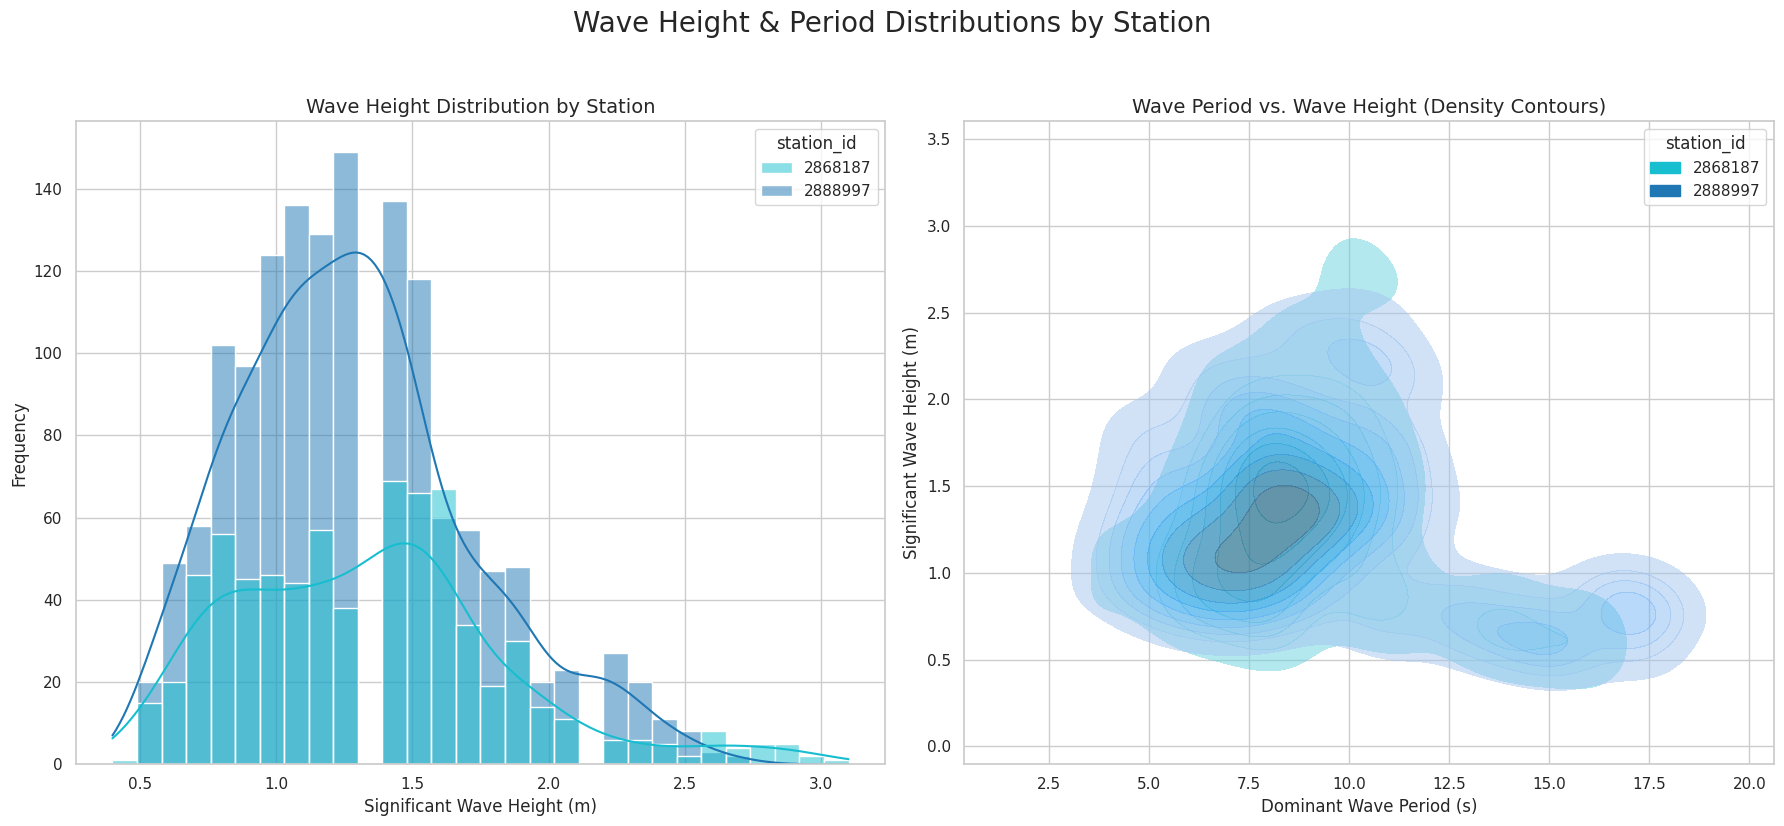

In [40]:
plt.figure(figsize=(18, 8))

# Wave Height Distribution by Station
plt.subplot(1, 2, 1)
sns.histplot(
    data=df.dropna(subset=['significant_wave_height_m']),
    x='significant_wave_height_m',
    hue='station_id',
    kde=True,
    palette='tab10_r'
)
plt.title('Wave Height Distribution by Station', fontsize=14)
plt.xlabel('Significant Wave Height (m)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Wave Period vs. Wave Height (Density Contours)
plt.subplot(1, 2, 2)
sns.kdeplot(
    data=df.dropna(subset=['dominant_wave_period_s', 'significant_wave_height_m']),
    x='dominant_wave_period_s',
    y='significant_wave_height_m',
    hue='station_id',
    fill=True,
    alpha=0.5,
    palette='tab10_r'
)
plt.title('Wave Period vs. Wave Height (Density Contours)', fontsize=14)
plt.xlabel('Dominant Wave Period (s)', fontsize=12)
plt.ylabel('Significant Wave Height (m)', fontsize=12)
plt.grid(True)

plt.suptitle('Wave Height & Period Distributions by Station', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

<table style="width:100%">
  <tbody>
    <tr>
      <td valign="top" style="width: 50%; padding-right: 15px;">
        <ul>
          <li>This plot shows the frequency of different wave heights for each station showing their distinct "wave personalities."</li>
          <li>
            <b>Station 2888997 (Light Blue):</b>
            <ul>
              <li>This station displays a single-peaked (unimodal) distribution, resembling a bell curve.</li>
              <li>The majority of its wave events are tightly clustered around a central peak of 1.2 to 1.4 meters.</li>
              <li>This indicates a stable and predictable wave climate, dominated by one primary type of sea state.</li>
            </ul>
          </li>
          <li>
            <b>Station 2868187 (Cyan):</b>
            <ul>
              <li>This station's distribution is much flatter, wider, and appears to have two peaks (bimodal).</li>
              <li>One peak occurs at lower wave heights (~0.8m), and a second, broader peak occurs at higher wave heights (~1.5m).</li>
              <li>This suggests a more complex and variable wave climate, influenced by at least two different, common conditions.</li>
            </ul>
          </li>
        </ul>
      </td>
      <td valign="top" style="width: 50%; padding-left: 15px;">
        <ul>
          <li>This density plot explains why the histograms look different by showing the relationship between wave height and period.</li>
          <li>
            <b>Station 2888997 (Darker Contours):</b>
            <ul>
              <li>Its density is a single, large "blob" centered around a period of 8-10 seconds and a height of ~1.3m.</li>
              <li>This confirms it is dominated by a single wave type of local wind-driven seas.</li>
            </ul>
          </li>
          <li>
            <b>Station 2868187 (Lighter, Cyan Contours):</b>
            <ul>
              <li>This plot shows two separate "islands" of high density, explaining its bimodal histogram.</li>
              <li><b>Island 1 ("Wind Sea"):</b> A large region centered at ~9 seconds and ~1.4m, which represents its local wind-driven waves.</li>
              <li><b>Island 2 ("Swell"):</b> A distinct, separate island is visible at a very long period (~16-18 seconds) and low height (~0.8m). This is the sign of long-period swell from distant storms.</li>
            </ul>
          </li>
          <li>The contour plot proves that Station 2868187's complex wave climate is due to it being influenced by both local wind seas and distant ocean swells, while Station 2888997 is primarily influenced by local winds alone. It is expected that in the geographic analysis Station 2888997 will be closer to the shore.</li>
        </ul>
      </td>
    </tr>
  </tbody>
</table>

### 4.3. Autocorrelation and Crosscorrelation Functions

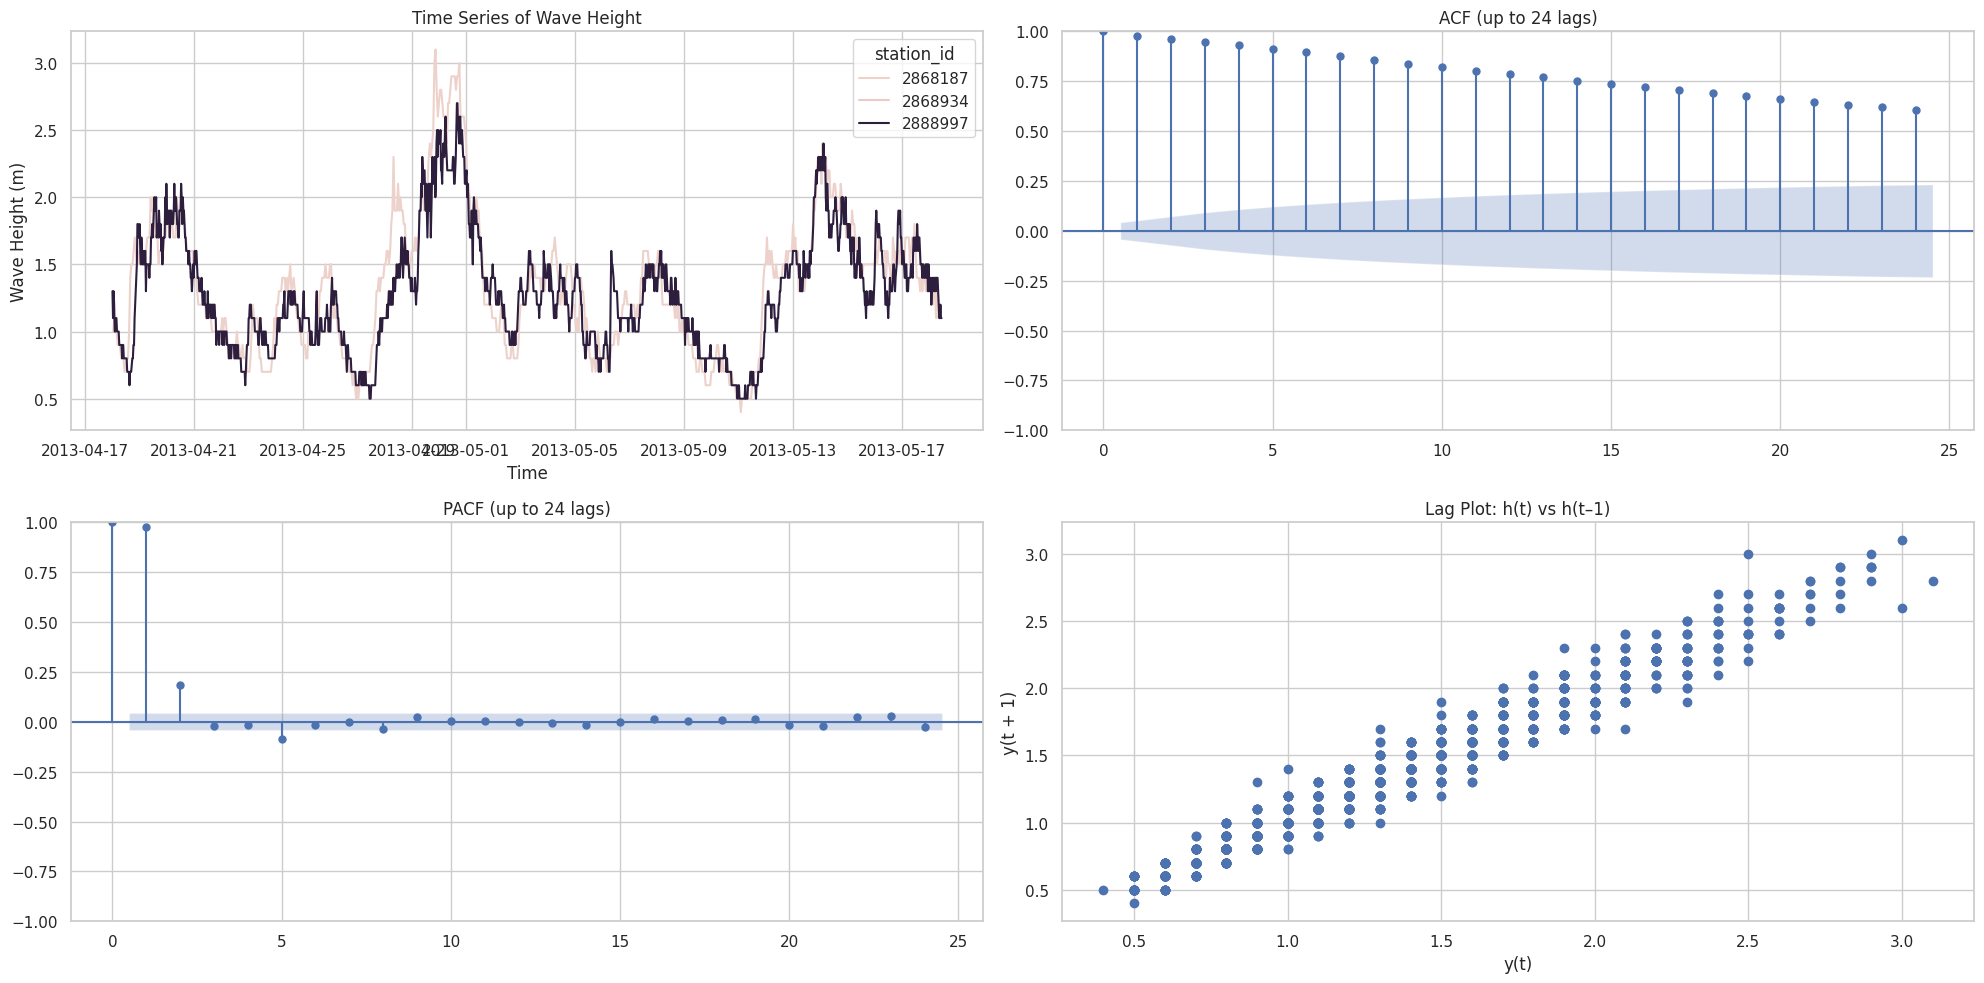

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# 1. Time series
sns.lineplot(
    data=df, 
    x='date_time', 
    y='significant_wave_height_m',
    hue='station_id',
    color='',
    ax=axs[0, 0]
)
axs[0, 0].set_title('Time Series of Wave Height')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Wave Height (m)')

# 2. ACF
plot_acf(df['significant_wave_height_m'].dropna(), lags=24, ax=axs[0, 1])
axs[0, 1].set_title('ACF (up to 24 lags)')

# 3. PACF
plot_pacf(df['significant_wave_height_m'].dropna(), lags=24, ax=axs[1, 0])
axs[1, 0].set_title('PACF (up to 24 lags)')

# 4. Lag plot
lag_plot(df['significant_wave_height_m'], lag=1, ax=axs[1, 1])
axs[1, 1].set_title('Lag Plot: h(t) vs h(t–1)')

plt.tight_layout()
plt.show()

**High Positive Correlation at initial lag:** The correlation at a lag of 1 hour is extremely high (approximately +0.95). This means the wave height at any given time is very similar to the wave height at the immediately preceding time step.

**Slow Decay:** The correlations remain significantly positive and decrease very slowly as the lag increases. Even after 24 time steps (lags), the correlation is still strong (around +0.6). The combination of a slowly decaying ACF (as seen in the top-right plot) and a PACF that cuts off sharply after a few lags is a sign of a strong trend or high persistence in the data. This is characteristic of a non-stationary time series or a strong autoregressive (AR) process.

**Persistence:** There is a strong positive linear pattern since the points on the Lag Plot are not scattered randomly. Instead, they form a distinct, upward-sloping band. A random time series would produce a formless, shapeless cloud of points with no discernible pattern but this clearly shows the significant wave height has a linear pattern. 

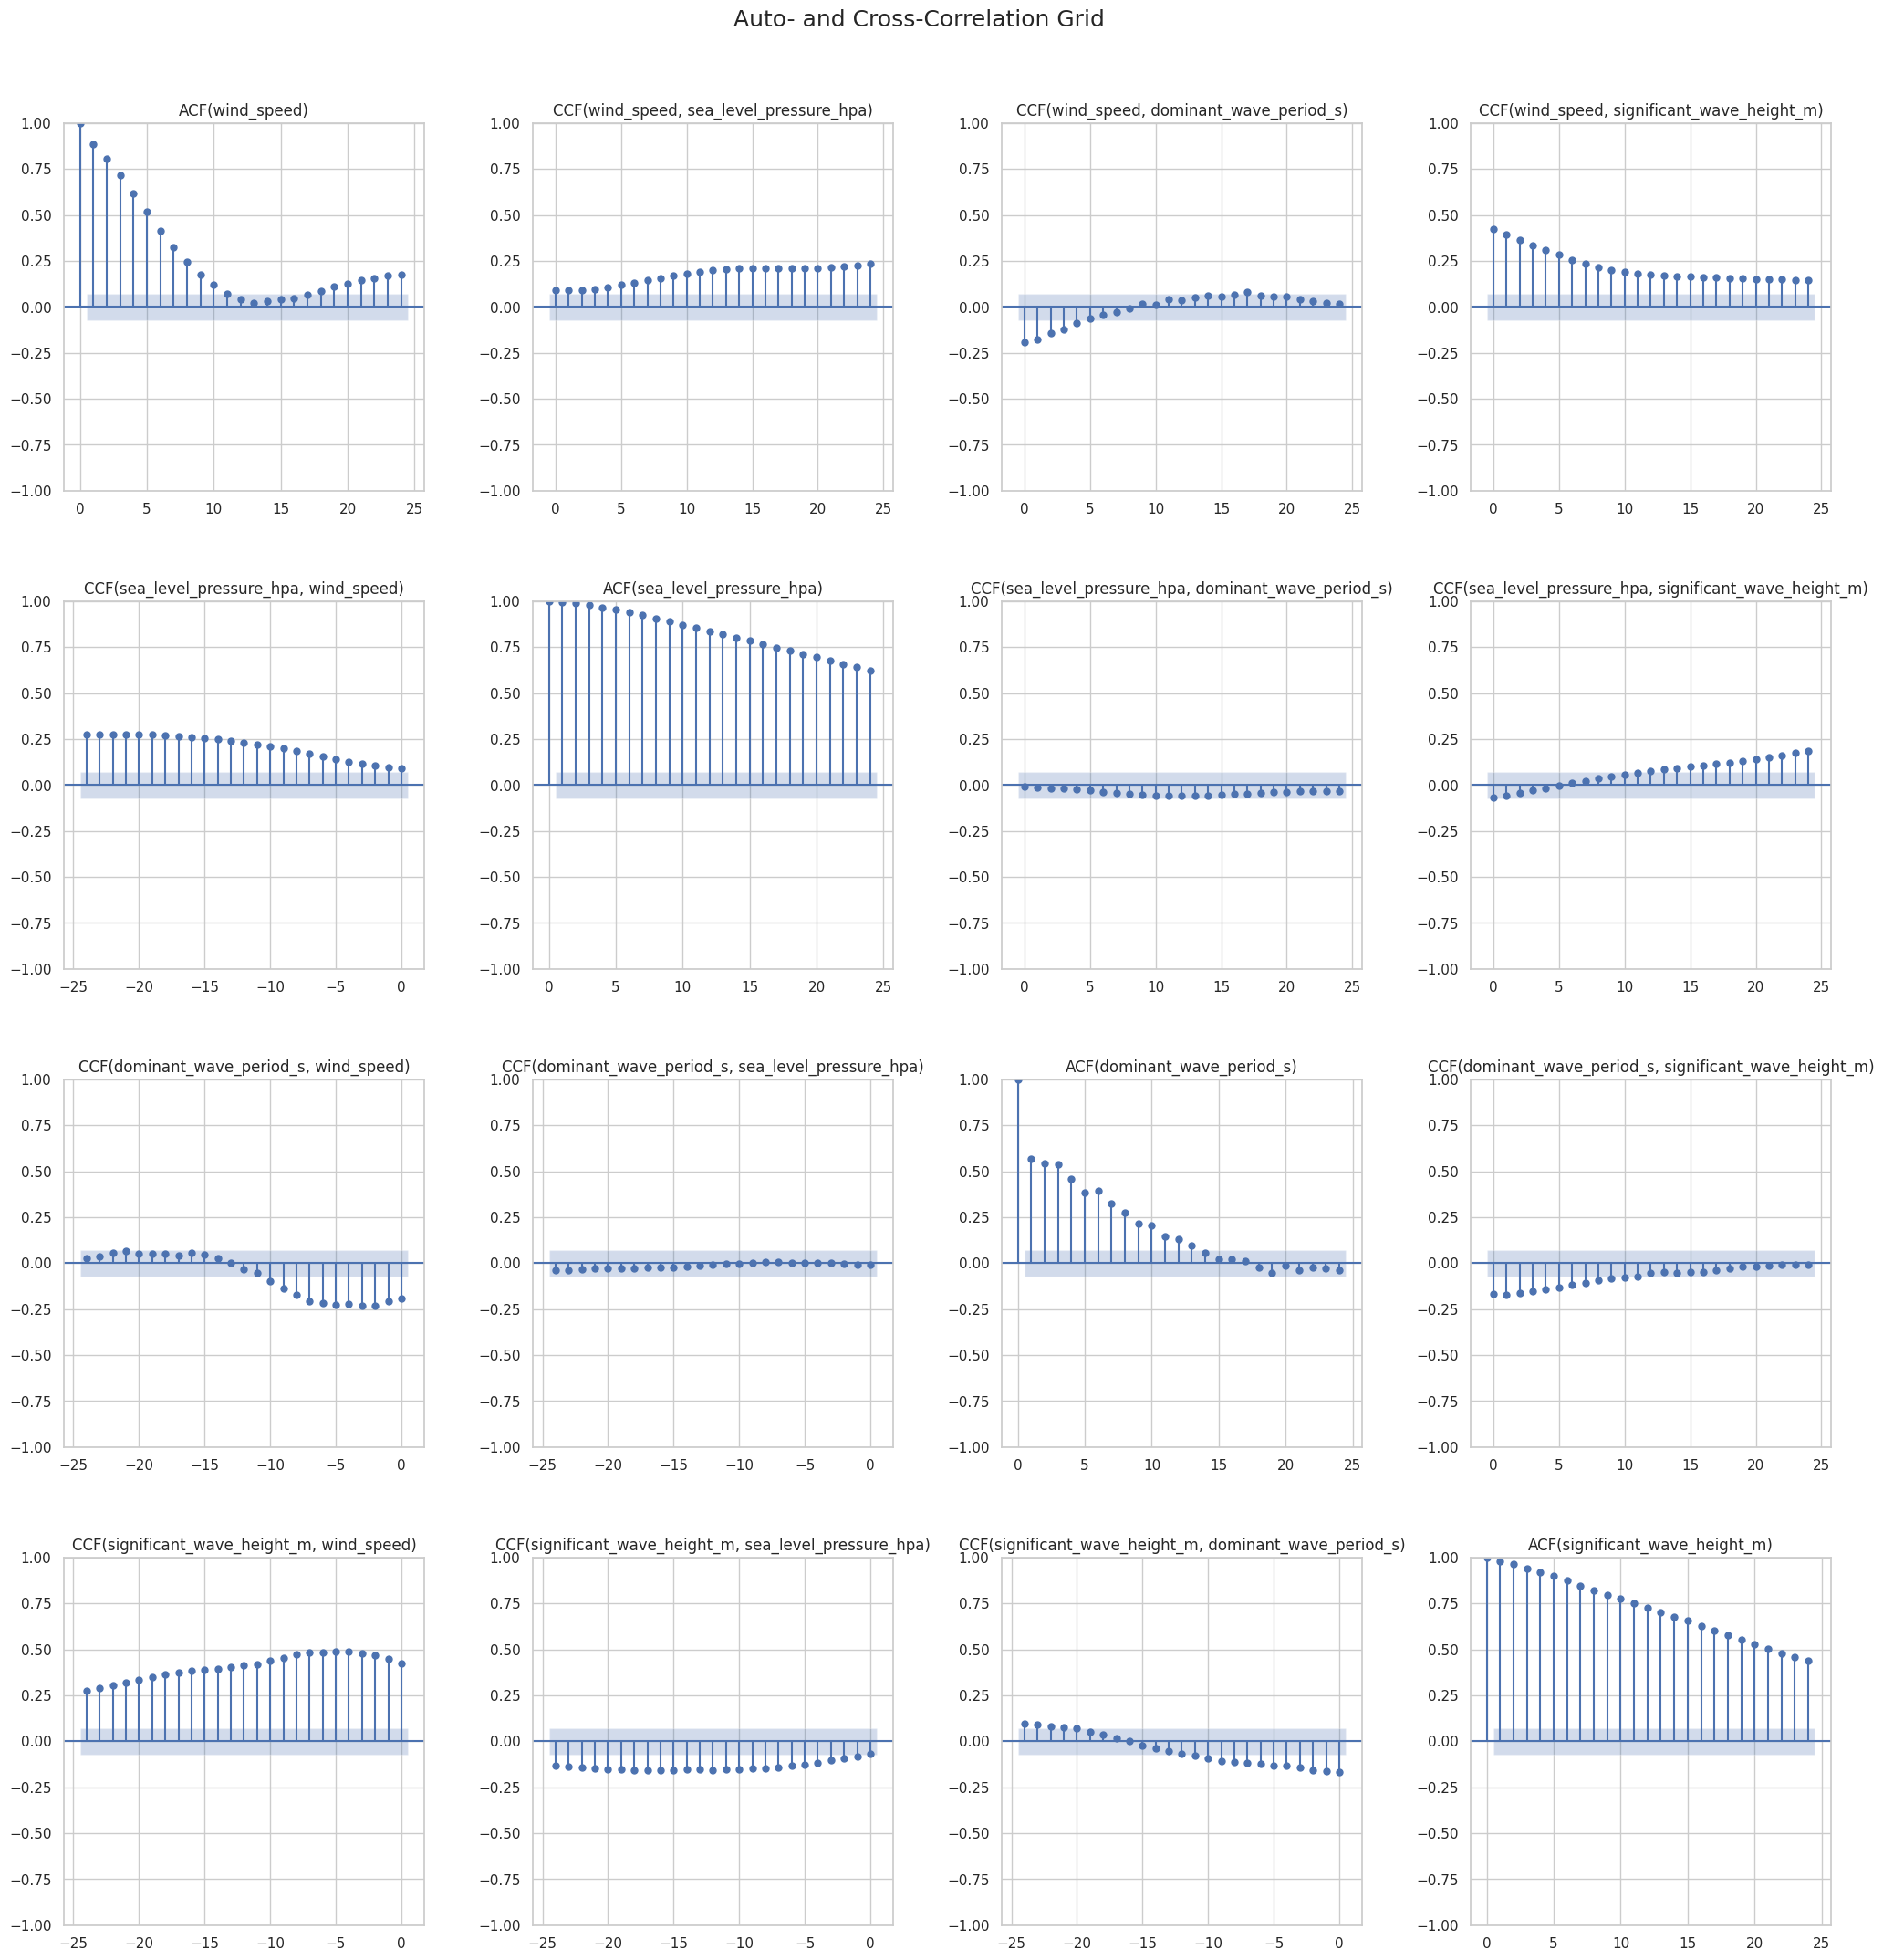

In [42]:
df_clean = df[['wind_speed', 'sea_level_pressure_hpa', 'dominant_wave_period_s', 'significant_wave_height_m']].dropna()
fig = plt.figure(figsize=(25, 25))
sm.graphics.tsa.plot_accf_grid(df_clean, fig=fig, lags=24, negative_lags=True)
fig.suptitle("Auto- and Cross-Correlation Grid", fontsize=18, y=0.95)
plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.3)
plt.show()

**Wind Speed and Wave Height:** The correlation between significant wave height and wind speed is positive and strong. Critically, the peak correlation is not at lag 0. The highest correlation values occur at negative lags (from roughly -1 to -8). For CCF(Y, X), negative lags show the correlation between Y(t) and X(t - lag). This means that `significant_wave_height_m` at time t has the strongest correlation with `wind_speed` at times t-1, t-2, ..., t-8. From this, it can be concluded that past wind speed predicts current wave height.

**Sea Level Pressure and Wave Height:** There is a consistent, weak negative correlation here. The peak is very close to lag 0. Lower sea-level pressure (often associated with storms) is weakly correlated with higher wave heights at roughly the same time.

**Dominant Wave Period and Wave Height:**  There is a weak negative correlation, with the strongest relationship happening at negative lags. A longer past wave period is slightly correlated with a lower current wave height. This relationship is less clear but might suggest that long, rolling swells (long periods) are associated with calmer conditions than chaotic, stormy seas (which might have higher waves but shorter, mixed periods).

### 4.3 Time-Series Analysis

Since the data is time-stamped, it's possible to analyze how the variables change over time. Time series plots can reveal trends, seasonality, and anomalous events. Key variables over time will be plotted for each station to observe their temporal behavior.

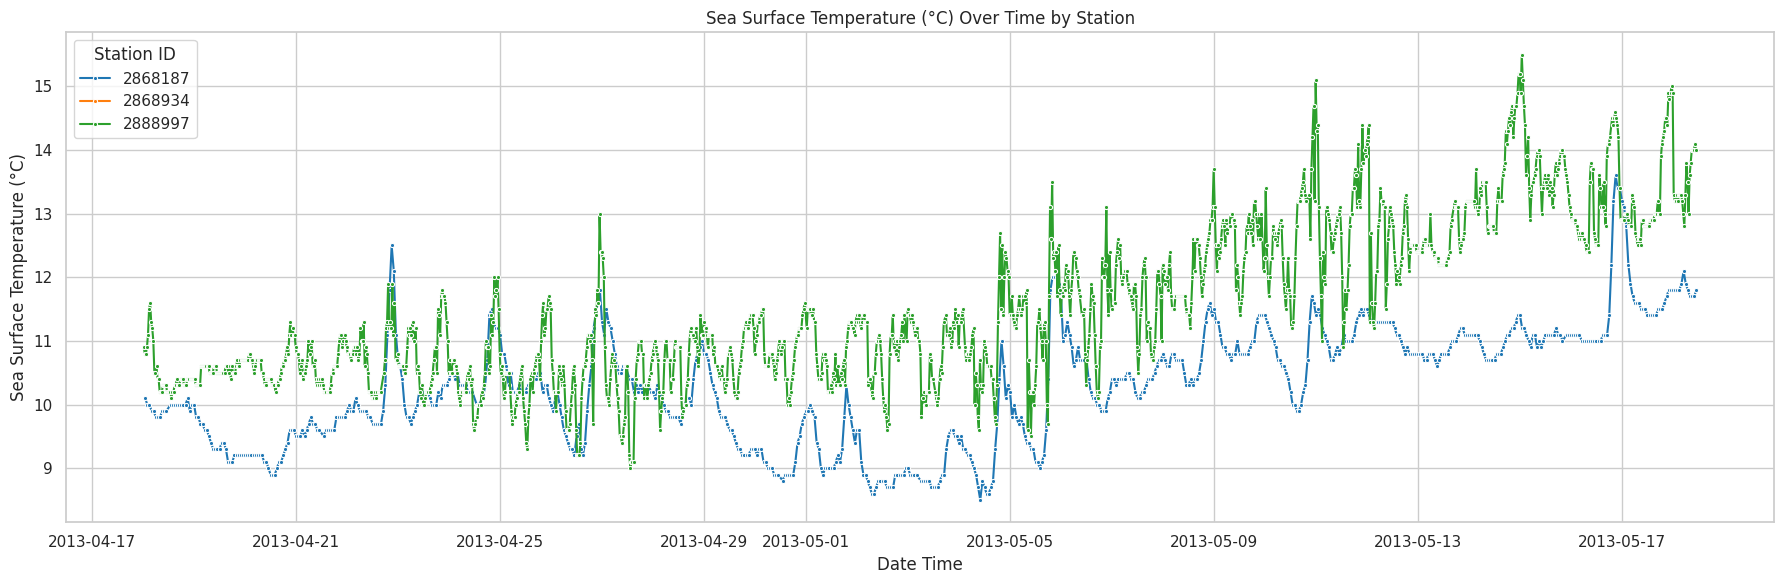

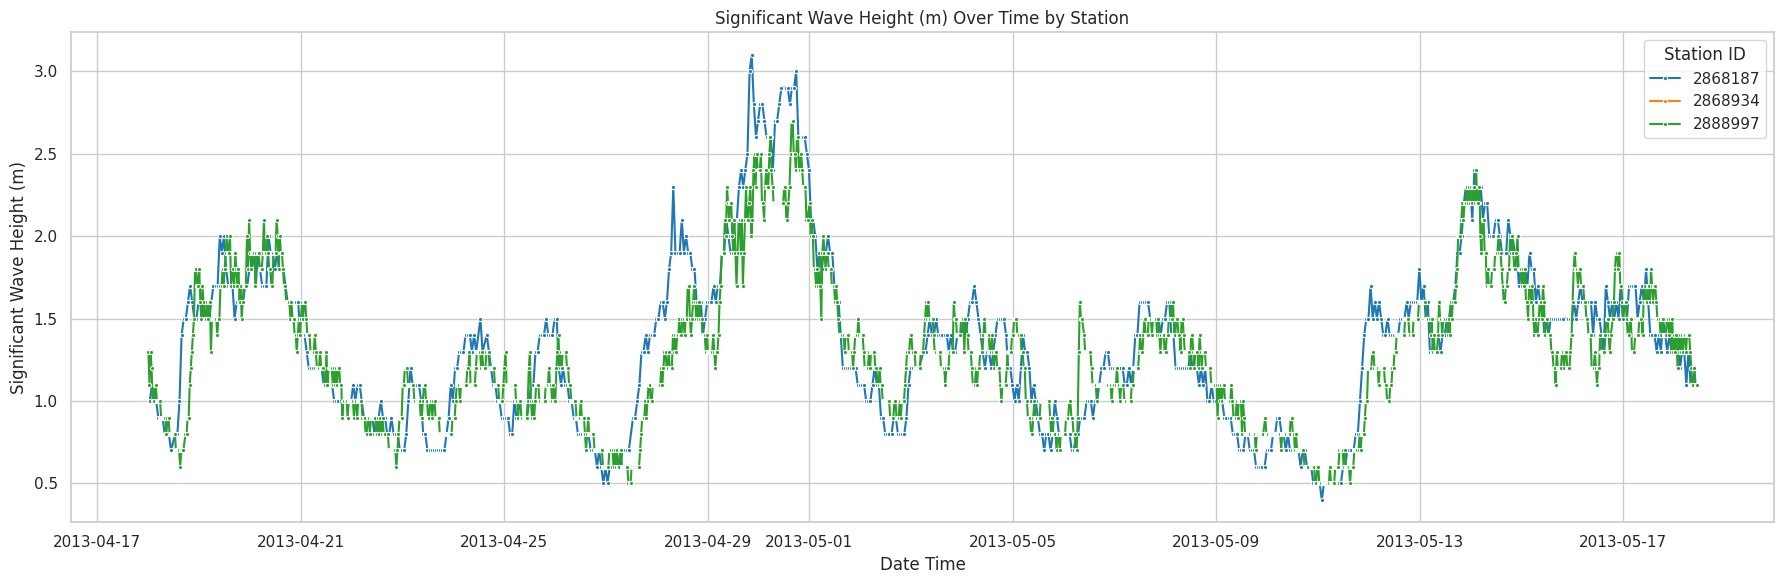

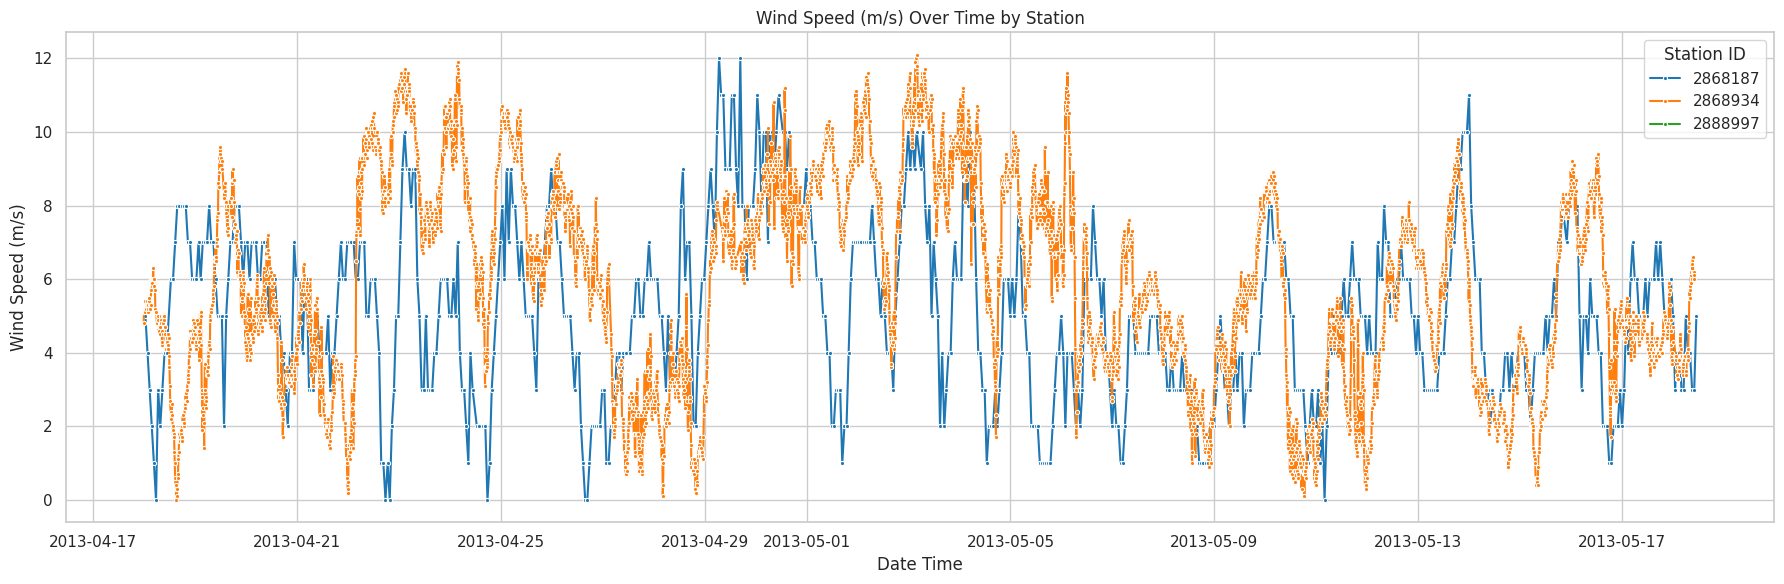

In [43]:
feature_titles = {
    'sea_surface_temperature_celsius': 'Sea Surface Temperature (°C)',
    'significant_wave_height_m': 'Significant Wave Height (m)',
    'wind_speed': 'Wind Speed (m/s)'
}

for col in ['sea_surface_temperature_celsius', 'significant_wave_height_m', 'wind_speed']:
    plt.figure(figsize=(18, 6))
    sns.lineplot(
        data=df,
        x='date_time',
        y=col,
        hue='station_id',
        palette='tab10',
        marker='.'
    )
    plt.title(f'{feature_titles.get(col, col.replace("_", " ").title())} Over Time by Station')
    plt.xlabel('Date Time')
    plt.ylabel(feature_titles.get(col, col.replace("_", " ").title()))
    plt.legend(title='Station ID')
    plt.tight_layout()
    plt.show()

**Sea Surface Temperature (°C) Over Time**

  - This plot shows that the different stations have distinct thermal signatures and that there is a seasonal warming trend.

  - Station 2868934 (Orange): This station is absent from the plot, confirming it does not measure sea surface temperature.

  - Station 2868187 (Blue): This station consistently reports the coldest water temperatures throughout the entire period.

  - Station 2888997 (Green): This station consistently reports the warmest water temperatures.

  - Seasonal Trend: Both stations show a clear, gradual upward trend in temperature from mid-April to mid-May.

  - Diurnal Cycle: The high-frequency "zig-zag" pattern, especially visible in the green line, represents the diurnal cycle—the water warms during the day and cools slightly at night.

**Significant Wave Height (m) Over Time**

  - The wave heights at the two relevant stations are highly correlated, indicating they are responding to the same regional weather systems.

  - Station 2868934 (Orange): This station is absent, confirming it does not measure waves.

  - The blue line (2868187) and the green line (2888997) track each other almost perfectly. They rise and fall at the same times, confirming that when a storm hits one station, it also hits the other.

  - The plot makes it easy to identify key storm periods by looking for the peaks. The most significant event is visible around April 29-30, where both stations recorded their maximum wave heights of over 3.0 meters. Other smaller events can be seen around April 20th and May 13th.

  - Between storms, the wave heights return to a baseline of around 1.0 to 1.5 meters.

**Wind Speed (m/s) Over Time**

  - The wind conditions are also highly correlated between the two measuring stations, but they show much more high-frequency variability than the waves.

  - Station 2888997 (Green): This station is absent, confirming it does not measure wind.

  - The blue line (2868187) and the orange line (2868934) track each other very well.

  - The major peak in wind speed around April 29-30 corresponds perfectly with the peak in wave heights, visually confirming the cause-and-effect relationship of the storm. Another significant wind event is visible around May 3-4.

  - Compared to the smoother wave height plot, the wind speed plot is much "spikier." This is expected, as wind speed can change much more rapidly moment-to-moment (gusts) than the overall sea state.

> **NOTE**
> 
> - The plots visually confirm which stations measure which variables. This confirms the "data silo" problem we identified earlier.
> 
> - The high correlation between the stations for both waves and wind demonstrates that they are all located within the same general weather region.
> 
> - The temperature plot is the only one that shows a consistent difference between the stations, with Station 2888997 always being warmer than 2868187.

### 4.4 Geographic Analysis

The datasets contain latitude and longitude information, which allows for visualization of the spatial locations of the NOAA buoys. A map provides a geographical context to the data and can help in understanding if spatial proximity influences the measurements.

In [44]:
# Get the mean location for each station to place a marker
station_info = df.groupby('station_id').agg({
    'latitude_(degrees_north)': 'mean',
    'longitude_(degrees_east)': 'mean',
    'significant_wave_height_m': 'mean',
    'wind_speed': 'mean'
})

# Create the map
map_center = [station_info['latitude_(degrees_north)'].mean(), station_info['longitude_(degrees_east)'].mean()]
m_icons = folium.Map(location=map_center, zoom_start=6)

# Logic for custom icons
for station_id, row in station_info.iterrows():
    # Determine station type and create a popup
    has_waves = pd.notna(row['significant_wave_height_m'])
    has_wind = pd.notna(row['wind_speed'])

    if has_waves and has_wind:
        icon_color = 'blue'
        icon_symbol = 'cloud' # Represents full weather
        popup_text = f"<b>Full Station: {station_id}</b><br>Avg Wave: {row['significant_wave_height_m']:.2f}m<br>Avg Wind: {row['wind_speed']:.2f} m/s"
    elif has_waves:
        icon_color = 'green'
        icon_symbol = 'water' # Represents waves
        popup_text = f"<b>Wave Buoy: {station_id}</b><br>Avg Wave: {row['significant_wave_height_m']:.2f}m"
    elif has_wind:
        icon_color = 'red'
        icon_symbol = 'wind' # Represents wind
        popup_text = f"<b>Wind Station: {station_id}</b><br>Avg Wind: {row['wind_speed']:.2f} m/s"

    folium.Marker(
        location=[row['latitude_(degrees_north)'], row['longitude_(degrees_east)']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color=icon_color, icon=icon_symbol, prefix='fa')
    ).add_to(m_icons)

html = m_icons.get_root()._repr_html_()
HTML(html)

In [45]:
# Find the index of the max wind speed for each station
peak_wind_indices = df.groupby('station_id')['wind_speed'].idxmax().dropna()
peak_wind_events = df.loc[peak_wind_indices]

# Find the index of the max wave height for each station
peak_wave_indices = df.groupby('station_id')['significant_wave_height_m'].idxmax().dropna()
peak_wave_events = df.loc[peak_wave_indices]


# Create a map with toggleable layers
m_combined = folium.Map(location=map_center, zoom_start=6, tiles="CartoDB positron")

# Create a layer for Peak Wave Events
wave_layer = folium.FeatureGroup(name='Peak Wave Events (Max Height)', show=True).add_to(m_combined)
for idx, row in peak_wave_events.iterrows():
    folium.CircleMarker(
        location=[row['latitude_(degrees_north)'], row['longitude_(degrees_east)']],
        radius=row['significant_wave_height_m'] * 5,
        popup=f"<b>Station {row['station_id']}</b><br>Peak Wave: {row['significant_wave_height_m']:.2f} m<br><b>Date: {row['date_time'].date()}</b>",
        color='crimson', fill=True, fill_color='crimson', fill_opacity=0.6
    ).add_to(wave_layer)

# Create a layer for Peak Wind Events
wind_layer = folium.FeatureGroup(name='Peak Wind Events (Max Speed)', show=True).add_to(m_combined)
for idx, row in peak_wind_events.iterrows():
    folium.CircleMarker(
        location=[row['latitude_(degrees_north)'], row['longitude_(degrees_east)']],
        radius=row['wind_speed'] * 1.5,
        popup=f"<b>Station {row['station_id']}</b><br>Peak Wind: {row['wind_speed']:.2f} m/s<br><b>Date: {row['date_time'].date()}</b>",
        color='royalblue', fill=True, fill_color='royalblue', fill_opacity=0.6
    ).add_to(wind_layer)

# Add a layer control panel to toggle layers on and off
folium.LayerControl().add_to(m_combined)

html = m_combined.get_root()._repr_html_()
HTML(html)

### 4.5 Extreme Weather Events

Average conditions are important, but extreme events often have the most impact. By identifying and isolating the data points corresponding to the most extreme conditions like peak wave height, we can analyze the behavior of all variables during these specific high-impact periods.

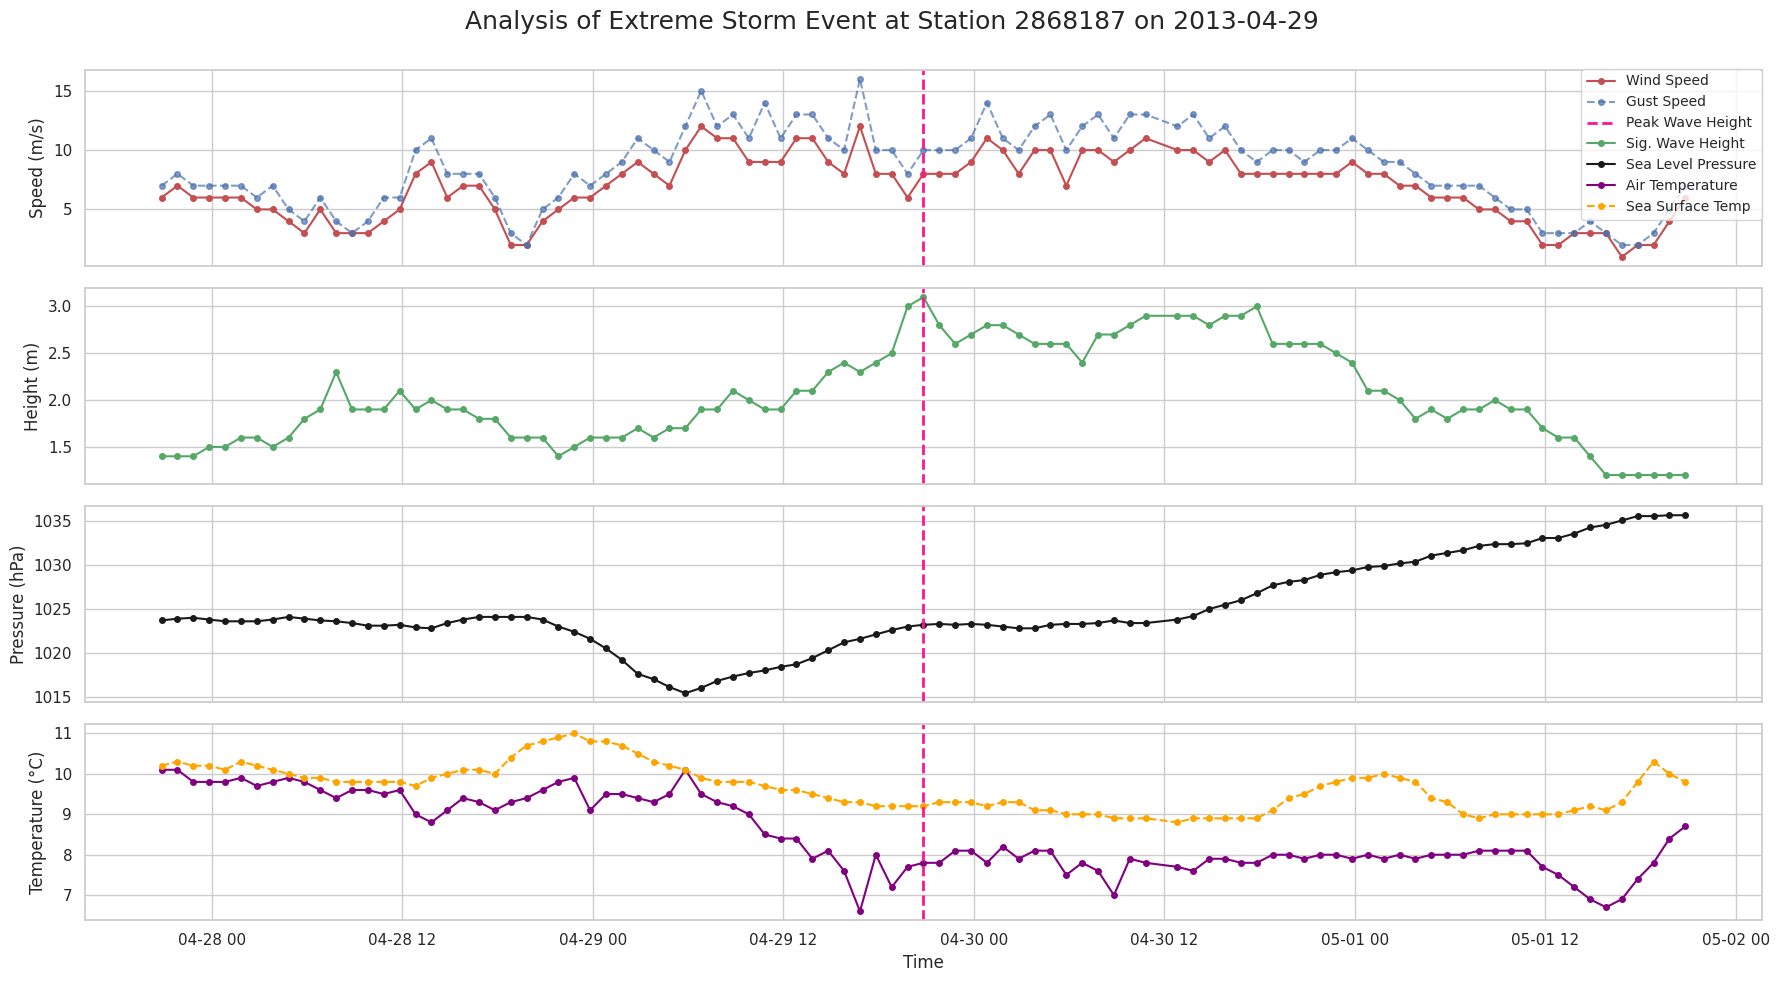

In [46]:
# Select only the data from the complete station
df_station = df[df['station_id'] == 2868187].copy()

# Find the row corresponding to the most extreme event (highest wave)
if not df_station.empty:
    event_df = df_station.sort_values('date_time')

    # Find the INDEX of the highest wave
    peak_index = event_df['significant_wave_height_m'].idxmax()
    peak_timestamp = event_df.loc[peak_index, 'date_time']

    # Define a 48hr time window around the peak
    start_time = peak_timestamp - pd.Timedelta(hours=48)
    end_time = peak_timestamp + pd.Timedelta(hours=48)
    event_df = event_df[(event_df['date_time'] >= start_time) & (event_df['date_time'] <= end_time)]

    fig, axes = plt.subplots(4, 1, figsize=(18, 10), sharex=True, dpi=100)
    fig.suptitle(f'Analysis of Extreme Storm Event at Station 2868187 on {peak_timestamp.date()}', fontsize=18)

    # Plot Wind and Gust Speed
    axes[0].plot(event_df['date_time'], event_df['wind_speed'], 'r-o', label='Wind Speed', markersize=4)
    axes[0].plot(event_df['date_time'], event_df['gust_speed_mps'], 'b--o', label='Gust Speed', markersize=4, alpha=0.7)
    axes[0].set_ylabel('Speed (m/s)')
    axes[0].grid(True)

    # Plot Significant Wave Height
    axes[1].plot(event_df['date_time'], event_df['significant_wave_height_m'], 'g-o', label='Sig. Wave Height', markersize=4)
    axes[1].set_ylabel('Height (m)')
    axes[1].grid(True)

    # Plot Sea Level Pressure
    axes[2].plot(event_df['date_time'], event_df['sea_level_pressure_hpa'], 'k-o', label='Sea Level Pressure', markersize=4)
    axes[2].set_ylabel('Pressure (hPa)')
    axes[2].grid(True)

    # Plot Air and Sea Temperature
    axes[3].plot(event_df['date_time'], event_df['air_temperature_celsius'], c='purple', ls='-', marker='o', ms=4, label='Air Temperature')
    axes[3].plot(event_df['date_time'], event_df['sea_surface_temperature_celsius'], c='orange', ls='--', marker='o', ms=4, label='Sea Surface Temp')
    axes[3].set_ylabel('Temperature (°C)')
    axes[3].grid(True)

    # Add a vertical line to all subplots
    for ax in axes:
        ax.axvline(x=peak_timestamp, color='deeppink', linestyle='--', linewidth=2, label='Peak Wave Height')

    # Create a single, clean legend for the entire figure
    handles, labels = [], []
    for ax in axes:
        h, current_labels = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(current_labels)
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper right', bbox_to_anchor=(0.987, 0.928), fontsize=10)

    plt.xlabel('Time', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

Relationship between the different measurements

- **Wind:** The rise in both sustained wind and gust speeds coincides closely with the rapid build-up of wave energy. As winds climb from ~6 m/s to ~12 m/s, Hs climbs from ~1.6 m to over 3 m.

- **Pressure:** The lowest pressure (~1015 hPa) occurs just before the highest waves form. A deepening low intensifies the pressure gradient ⇒ stronger winds ⇒ larger waves.

- **Lag effects:** Peak gusts occur slightly before or concurrent with wave-height peaks, reflecting the time it takes for wind energy to transfer into the wave field.

- **Temperature:** Both air temperature and sea-surface temperature dip around the storm center (cold advection and mixing), but their variations are much smaller compared to the wind–wave coupling.

Information about the event from the National Climatic Data Center (NCDC)

- A strong cold front pressed through the Inland Northwest during the morning hours of April 29th. Deep cold advection coupled with tightly packed pressure gradients led to strong winds across all of Eastern Washington with numerous observation platforms measuring sustained winds of 25 to 35 mph and gusts between 40 and 55 mph. This led to numerous power outages, especially in the northern mountain zones, likely due to downed trees and tree limbs.

- Most observation platforms in the Okanogan Highlands of Washington experience some degree of sheltering and more then likely do not measure the actual wind gusts that are occurring during wind storms. 128 customers in Boyd experienced power outages due to either a downed tree or tree limb falling onto power-lines.

## References

[1] National Oceanic and Atmospheric Administration, U.S. Department of Commerce, “Observation Data Descriptions.” NDBC. Accessed: July 10, 2025. [Online]. Available: [https://www.ndbc.noaa.gov/obsdes.shtml](https://www.ndbc.noaa.gov/obsdes.shtml).

[2] National Oceanic and Atmospheric Administration, U.S. Department of Commerce, “NDBC Station List.” NDBC. Accessed: July 10, 2025. [Online]. Available: [https://www.ndbc.noaa.gov/to_station.shtml](https://www.ndbc.noaa.gov/to_station.shtml).

[3] W. F. Guthrie, “NIST/SEMATECH e-Handbook of Statistical Methods (NIST Handbook 151).” National Institute of Standards and Technology, 2020. doi: [https://doi.org/10.18434/M32189](10.18434/M32189). Available: [https://www.itl.nist.gov/div898/handbook/](https://www.itl.nist.gov/div898/handbook/).

[4] R. J. Hyndman and G. Athanasopoulos, *Forecasting: Principles and Practice*, 3rd ed. Melbourne, Australia: OTexts, 2021. Accessed: Jul. 20, 2025. [Online]. Available: [https://otexts.com/fpp3/](https://otexts.com/fpp3/).